In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import re
import os


# Part 1 - changing consentration

In [8]:
pip install odfpy

     ---------------------------------------- 0.0/717.0 kB ? eta -:--:--
      --------------------------------------- 10.2/717.0 kB ? eta -:--:--
     - ----------------------------------- 20.5/717.0 kB 217.9 kB/s eta 0:00:04
     - ----------------------------------- 30.7/717.0 kB 217.9 kB/s eta 0:00:04
     -- ---------------------------------- 41.0/717.0 kB 245.8 kB/s eta 0:00:03
     --- --------------------------------- 61.4/717.0 kB 297.7 kB/s eta 0:00:03
     ------- ---------------------------- 143.4/717.0 kB 532.5 kB/s eta 0:00:02
     --------------- -------------------- 307.2/717.0 kB 999.9 kB/s eta 0:00:01
     -------------------------------- ----- 604.2/717.0 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 717.0/717.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=137514 sha256=cfa045a7a56d8f4a9865024

In [9]:


df = pd.read_excel("flu/flu_0.01.ods",engine="odf",sheet_name=0)        
print(df.head())


   X [nm (air)]  Y [Intensity]
0    321.590820       0.005632
1    321.698334       0.001266
2    321.805878       0.003098
3    321.913422       0.013078
4    322.020966       0.007484


In [3]:


materials = ["flu", "R6G", "RhB"]

data_dict = {}

for mat in materials:
    measurements = []
    
    # Loop over files in e.g. "./flu"
    for fname in sorted(os.listdir(mat)):
        if fname.startswith(f"{mat}_") and fname.endswith(".ods"):
            # parse out the concentration
            conc = float(fname[len(mat)+1:-4])   
            
            path = os.path.join(mat, fname)
            df = pd.read_excel(path, engine="odf", sheet_name=0)
            
            measurements.append([conc, df])
    
    data_dict[mat] = measurements

# sanity check
for mat, lst in data_dict.items():
    print(f"{mat}: {len(lst)} files loaded")

    print(data_dict)

flu: 10 files loaded
{'flu': [[0.0001,       X [nm (air)]  Y [Intensity]
0       321.590820       0.005545
1       321.698334       0.001654
2       321.805878       0.004011
3       321.913422       0.012997
4       322.020966       0.007624
...            ...            ...
3643    744.272034      -0.059505
3644    744.392334      -0.061464
3645    744.512573      -0.061576
3646    744.632812      -0.061909
3647    744.753052      -0.061651

[3648 rows x 2 columns]], [0.0005,       X [nm (air)]  Y [Intensity]
0       321.590820       0.006209
1       321.698334       0.001820
2       321.805878       0.003550
3       321.913422       0.013347
4       322.020966       0.008384
...            ...            ...
3643    744.272034      -0.059939
3644    744.392334      -0.061982
3645    744.512573      -0.062210
3646    744.632812      -0.062402
3647    744.753052      -0.062443

[3648 rows x 2 columns]], [0.0008,       X [nm (air)]  Y [Intensity]
0       321.590820       0.005122
1    

In [4]:
for i in range(10):
    data_dict['flu'][i][1]['wavel'] = data_dict['flu'][i][1]['X [nm (air)]']
    data_dict['R6G'][i][1]['wavel'] = data_dict['R6G'][i][1]['X [nm (air)]']
    data_dict['RhB'][i][1]['wavel'] = data_dict['RhB'][i][1]['X [nm (air)]']

    data_dict['flu'][i][1]['I'] = data_dict['flu'][i][1]['Y [Intensity]']
    data_dict['R6G'][i][1]['I'] = data_dict['R6G'][i][1]['Y [Intensity]']
    data_dict['RhB'][i][1]['I'] = data_dict['RhB'][i][1]['Y [Intensity]']

    data_dict['flu'][i][1] = data_dict['flu'][i][1][['wavel', 'I']]
    data_dict['R6G'][i][1] = data_dict['R6G'][i][1][['wavel', 'I']]
    data_dict['RhB'][i][1] = data_dict['RhB'][i][1][['wavel', 'I']]

data_dict['R6G'][5][1]


wavel         I
0     321.590820  0.008583
1     321.698334  0.001964
2     321.805878  0.002861
3     321.913422  0.017479
4     322.020966  0.010074
...          ...       ...
3643  744.272034 -0.067284
3644  744.392334 -0.069030
3645  744.512573 -0.069405
3646  744.632812 -0.069429
3647  744.753052 -0.069447

[3648 rows x 2 columns]

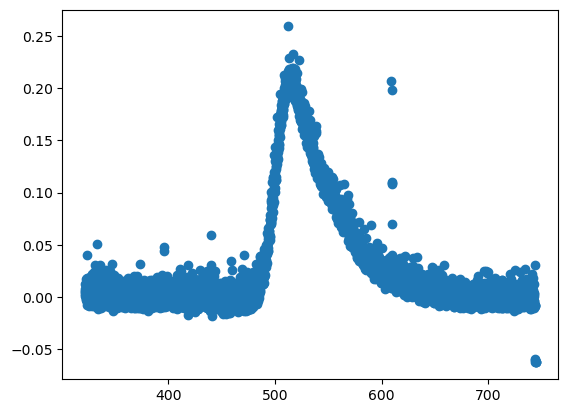

In [98]:
plt.scatter(data_dict['flu'][9][1]['wavel'], data_dict['flu'][5][1]['I'])

In [23]:

# Build a new dict of DataFrames (no in-place modification)
integrals = {}

for mat, measurements in data_dict.items():
    records = []
    for conc, df in measurements:
        # Filter λ ≥ 450 nm, sort
        df = df[df['I'] >= 0]
        df_cut = df[df['wavel'] >= 450].sort_values('wavel')
        x = df_cut['wavel'].to_numpy()
        y = df_cut['I'].to_numpy()
        n = len(x)
        
        # Compute widths
        widths = np.zeros(n)
        for i in range(n):
            if i == 0:
                widths[i] = x[1] - x[0]
            elif i == n - 1:
                widths[i] = x[-1] - x[-2]
            else:
                widths[i] = (x[i+1] - x[i-1]) / 2
        
        # Total area and propagated error
        area = np.sum(y * widths)/8
        #err = np.sqrt(np.sum((widths**2) * y))
        err = np.sqrt(area)/8
        
        records.append({
            'concentration': conc,
            'integral': area,
            'error': err
        })
    
    integrals[mat] = pd.DataFrame(records)

# Display the integrals DataFrame for each material
for mat, df_int in integrals.items():
    print(f"\n=== {mat} ===")
    display(df_int)



=== flu ===


concentration  integral     error
0         0.0001  0.256621  0.063322
1         0.0005  0.345946  0.073521
2         0.0008  0.430144  0.081982
3         0.0010  0.491609  0.087644
4         0.0025  0.999368  0.124960
5         0.0050  1.676406  0.161845
6         0.0100  2.875101  0.211952
7         0.0250  4.834391  0.274841
8         0.0500  5.980175  0.305680
9         0.1000  4.539906  0.266338


=== R6G ===


concentration  integral     error
0         0.0001  0.328479  0.071641
1         0.0005  0.335908  0.072447
2         0.0008  0.350169  0.073969
3         0.0010  0.365450  0.075566
4         0.0025  0.590489  0.096054
5         0.0050  0.973158  0.123311
6         0.0100  1.761993  0.165925
7         0.0250  3.435507  0.231689
8         0.0500  4.483936  0.264691
9         0.1000  4.304948  0.259355


=== RhB ===


concentration  integral     error
0         0.0001  0.326895  0.071468
1         0.0005  0.332911  0.072123
2         0.0008  0.327976  0.071586
3         0.0010  0.324255  0.071179
4         0.0025  0.337686  0.072638
5         0.0050  0.363578  0.075372
6         0.0100  0.603200  0.097082
7         0.0250  0.443811  0.083274
8         0.0500  0.792884  0.111305
9         0.1000  0.937613  0.121038

In [92]:
integrals['Fluorescence'].iloc

concentration  integral     error
0         0.0001  0.256621  0.063322
1         0.0005  0.345946  0.073521
2         0.0008  0.430144  0.081982
3         0.0010  0.491609  0.087644
4         0.0025  0.999368  0.124960
5         0.0050  1.676406  0.161845
6         0.0100  2.875101  0.211952
7         0.0250  4.834391  0.274841
8         0.0500  5.980175  0.305680
9         0.1000  4.539906  0.266338

flu


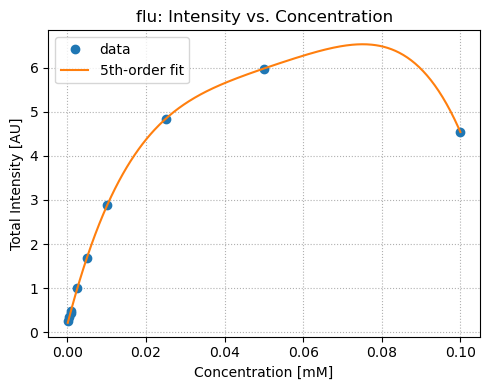

R6G


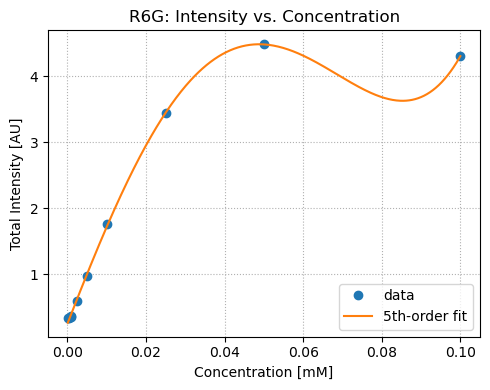

RhB


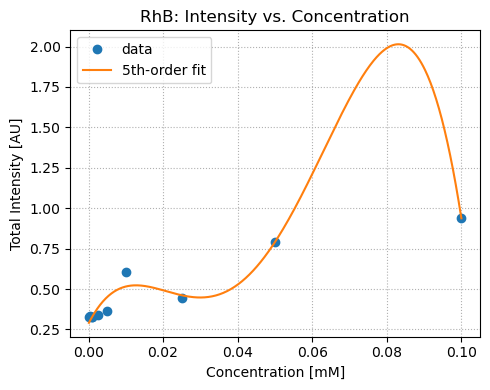

Fluorescence


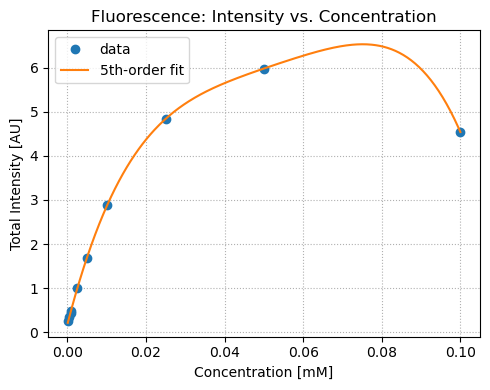

In [39]:
import numpy as np
import matplotlib.pyplot as plt

for mat, df_int in integrals.items():
    print(mat)
    # raw data
    x = np.asarray(df_int['concentration'])
    y = np.asarray(df_int['integral'])
    # 5th-degree polynomial fit
    coeff_p5 = np.polyfit(x, y, deg=4)

    # -------- higher-resolution curve ------------------------------
    x_fit = np.linspace(x.min(), x.max(), 400)   # 400 points ≫ original sample size
    y_fit = np.polyval(coeff_p5, x_fit)
    # ----------------------------------------------------------------

    plt.figure(figsize=(5, 4))
    plt.plot(x,     y,      'o',  ms=6, label='data')
    plt.plot(x_fit, y_fit,  '-',       label='5th-order fit')

    plt.xlabel('Concentration [mM]')
    plt.ylabel('Total Intensity [AU]')
    plt.title(f'{mat}: Intensity vs. Concentration')
    plt.grid(True, ls=':')
    plt.legend()
    plt.tight_layout()
    plt.show()


flu


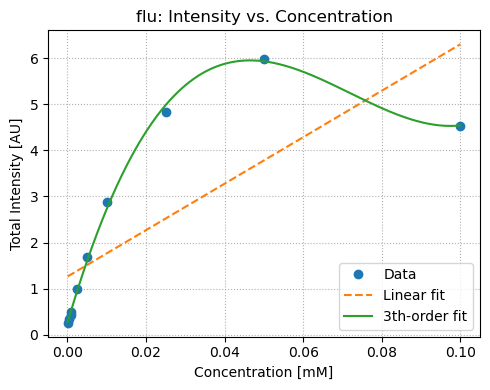

R6G


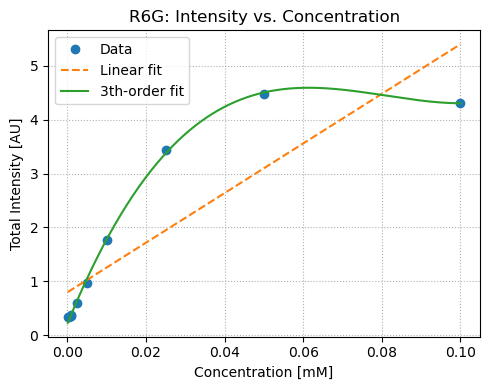

RhB


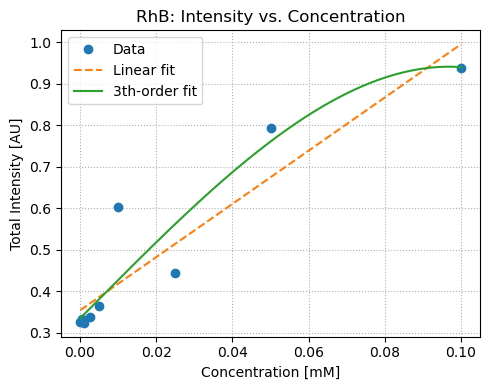

Fluorescence


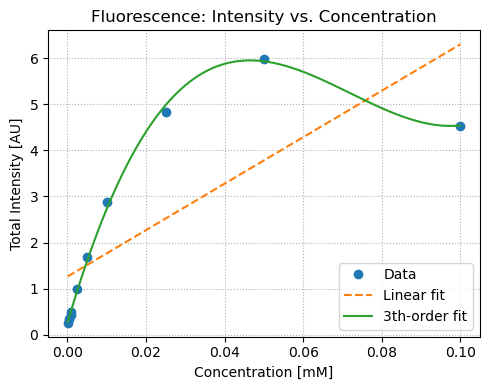

In [91]:
import numpy as np
import matplotlib.pyplot as plt

for mat, df_int in integrals.items():
    print(mat)
    
    # raw data
    x = np.asarray(df_int['concentration'])
    y = np.asarray(df_int['integral'])

    # Linear fit
    coeff_lin = np.polyfit(x, y, deg=1)
    y_lin     = np.polyval(coeff_lin, x_fit)

    # 4th-degree polynomial fit
    coeff_p4 = np.polyfit(x, y, deg=3)
    x_fit    = np.linspace(x.min(), x.max(), 400)
    y_p4     = np.polyval(coeff_p4, x_fit)

    # Plot
    plt.figure(figsize=(5, 4))
    plt.plot(x,     y,     'o',  ms=6, label='Data')
    plt.plot(x_fit, y_lin, '--',        label='Linear fit')
    plt.plot(x_fit, y_p4,  '-',         label='3th-order fit')

    plt.xlabel('Concentration [mM]')
    plt.ylabel('Total Intensity [AU]')
    plt.title(f'{mat}: Intensity vs. Concentration')
    plt.grid(True, ls=':')
    plt.legend()
    plt.tight_layout()
    plt.show()


flu


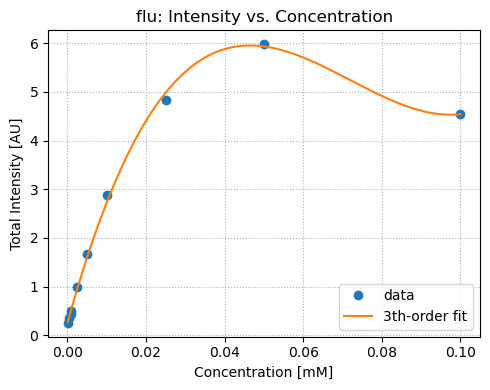

R6G


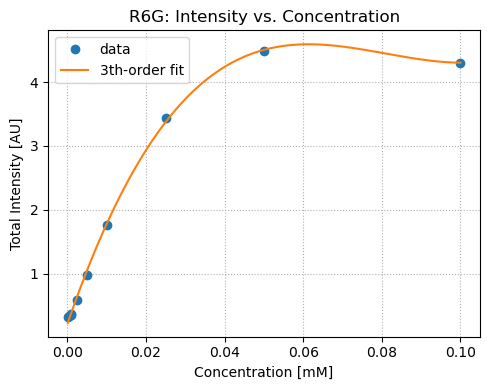

RhB


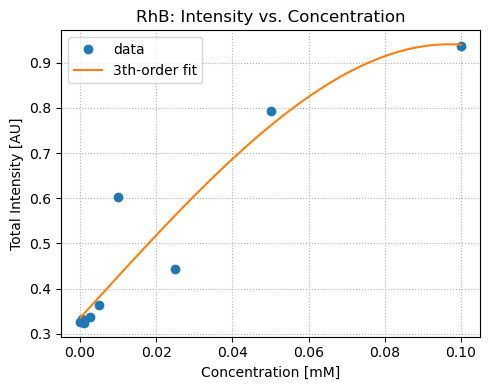

Fluorescence


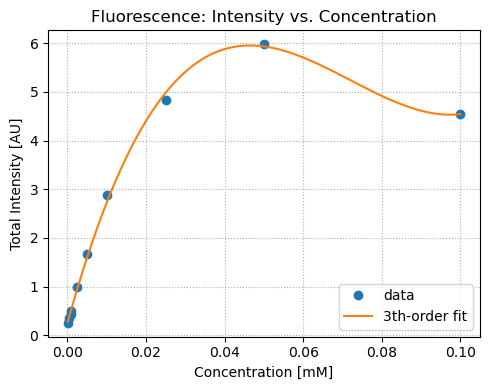

In [30]:
import numpy as np
import matplotlib.pyplot as plt

for mat, df_int in integrals.items():
    print(mat)
    # raw data
    x = np.asarray(df_int['concentration'])
    y = np.asarray(df_int['integral'])
    # 5th-degree polynomial fit
    coeff_p5 = np.polyfit(x, y, deg=3)

    # -------- higher-resolution curve ------------------------------
    x_fit = np.linspace(x.min(), x.max(), 400)   # 400 points ≫ original sample size
    y_fit = np.polyval(coeff_p5, x_fit)
    # ----------------------------------------------------------------

    plt.figure(figsize=(5, 4))
    plt.plot(x,     y,      'o',  ms=6, label='data')
    plt.plot(x_fit, y_fit,  '-',       label='3th-order fit')

    plt.xlabel('Concentration [mM]')
    plt.ylabel('Total Intensity [AU]')
    plt.title(f'{mat}: Intensity vs. Concentration')
    plt.grid(True, ls=':')
    plt.legend()
    plt.tight_layout()
    plt.show()


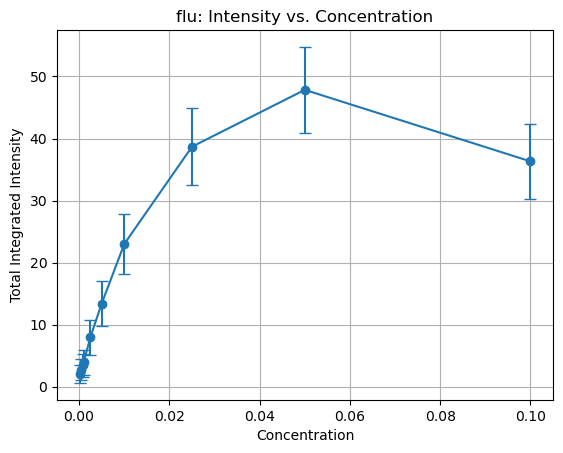

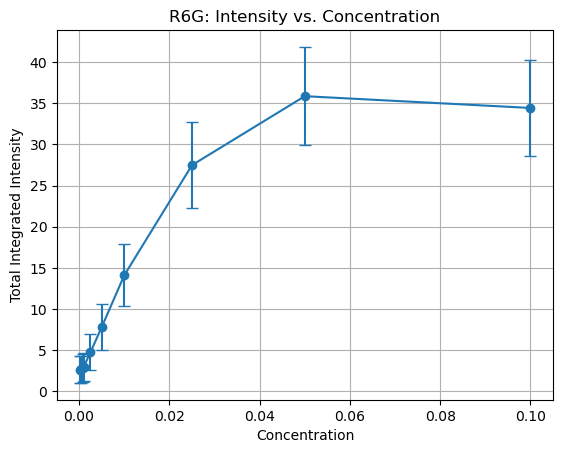

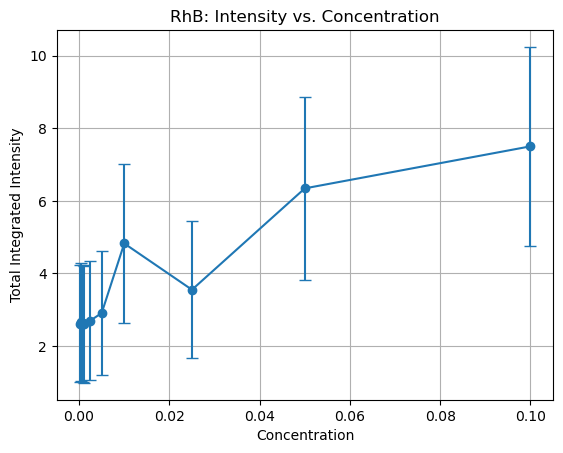

In [88]:
import matplotlib.pyplot as plt

# Plot for each material
for mat, df_int in integrals.items():
    plt.figure()
    plt.errorbar(
        df_int['concentration'],
        df_int['integral'],
        yerr=df_int['error'],
        fmt='o-',
        capsize=4
    )
    plt.xlabel('Concentration [mM]')
    plt.ylabel('Total Intensity [AU]')
    plt.title(f'{mat}: Intensity vs. Concentration')
    plt.grid(True)
    plt.show()


In [3]:

def load_fluorescence_data(base_dir):
    materials = ['flu', 'R6G', 'RhB']
    data = {}

    for material in materials:
        folder_path = os.path.join(base_dir, material)
        material_list = []
        
        for fname in sorted(os.listdir(folder_path)):
            fpath = os.path.join(folder_path, fname)
            
            # Attempt to extract a concentration (e.g., from "R6G_0.2.txt")
            try:
                concentration = float(''.join(c if c.isdigit() or c == '.' or c == '-' else ' ' for c in fname).split()[0])
            except (ValueError, IndexError):
                continue  # Skip files that don't have a parsable concentration
            
            df = pd.read_csv(fpath, delim_whitespace=True, header=None)
            material_list.append([concentration, df])
        
        data[material] = material_list
    
    return data


# Part 2 - changing path length

In [40]:
concs = {1: 1e-4, 2: 5e-4, 3:8e-4, 4: 0.001, 5: 0.0025, 6: 0.005, 7: 0.01, 8: 0.025,9: 0.05, 10: 0.1}

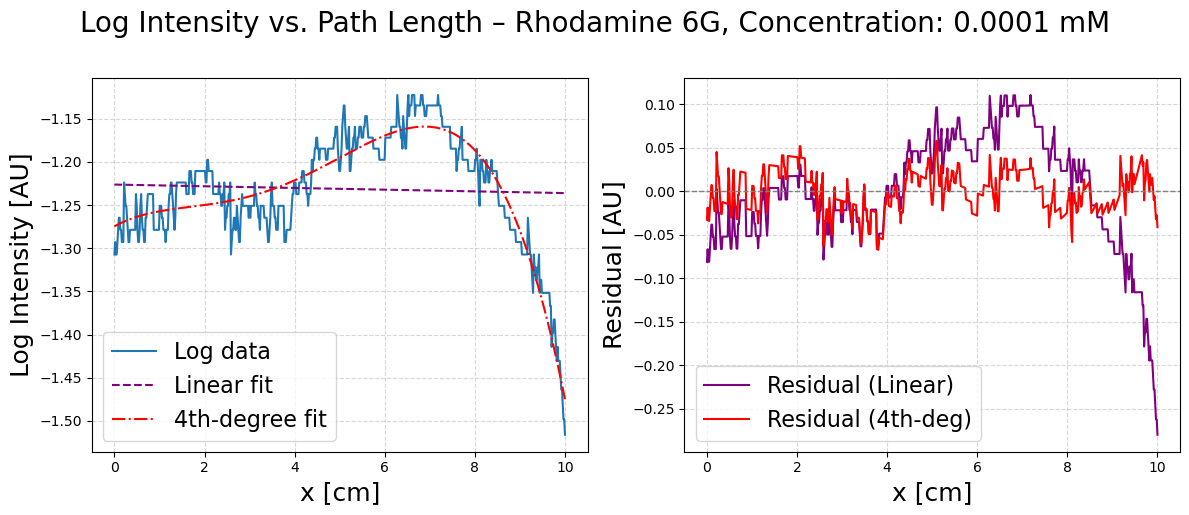

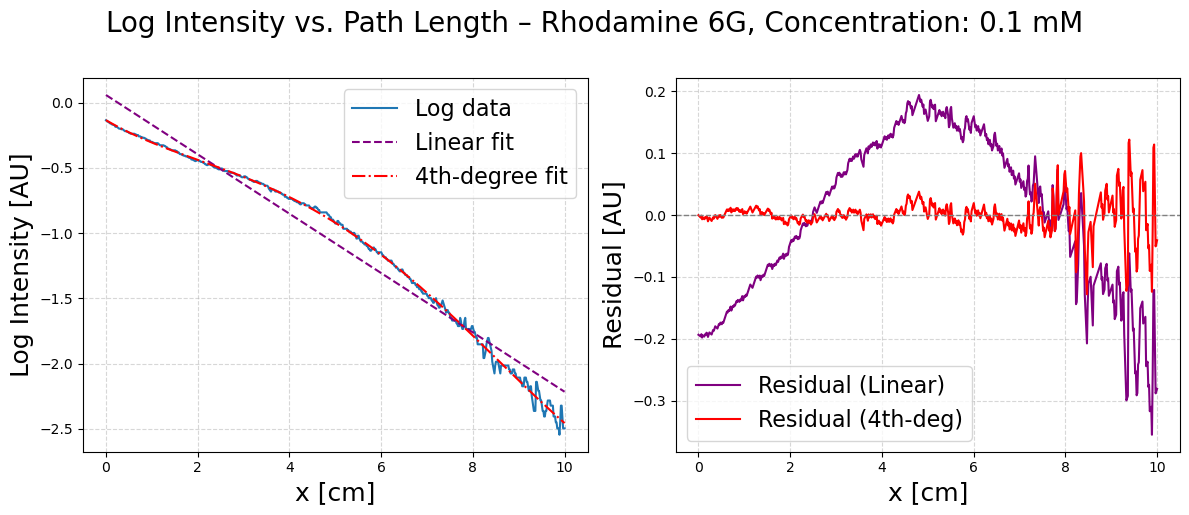

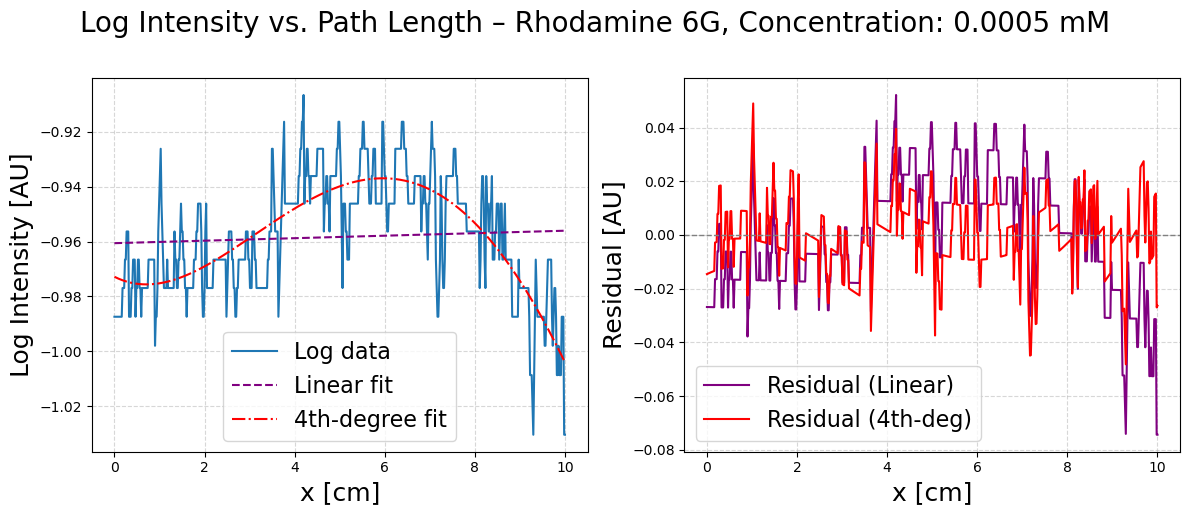

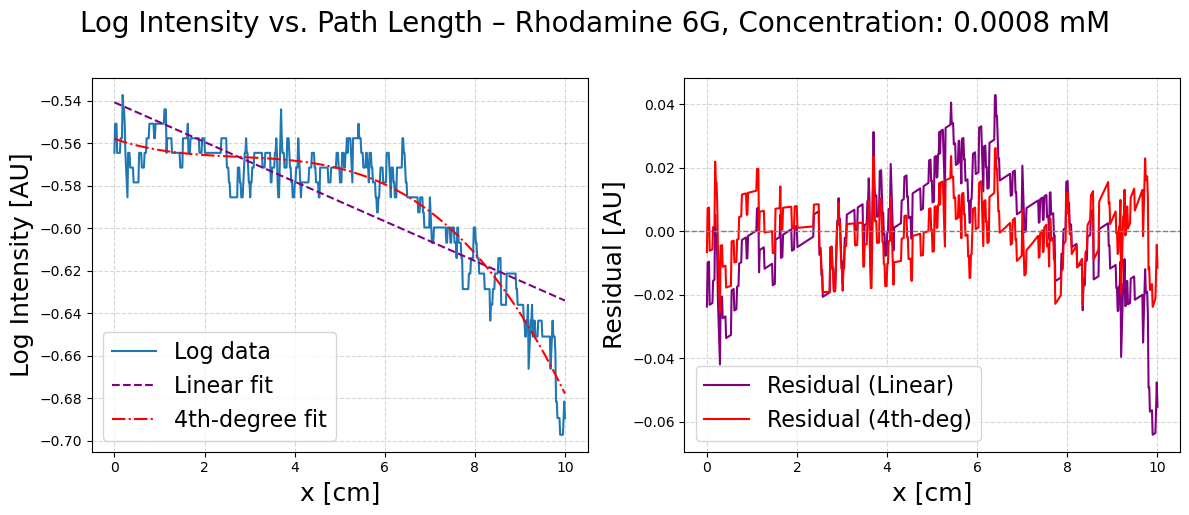

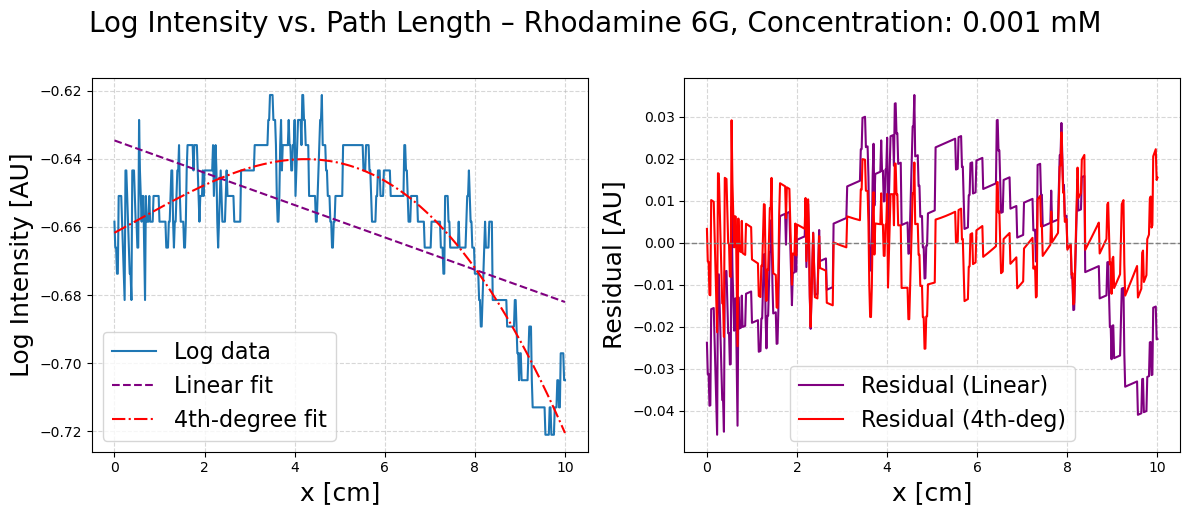

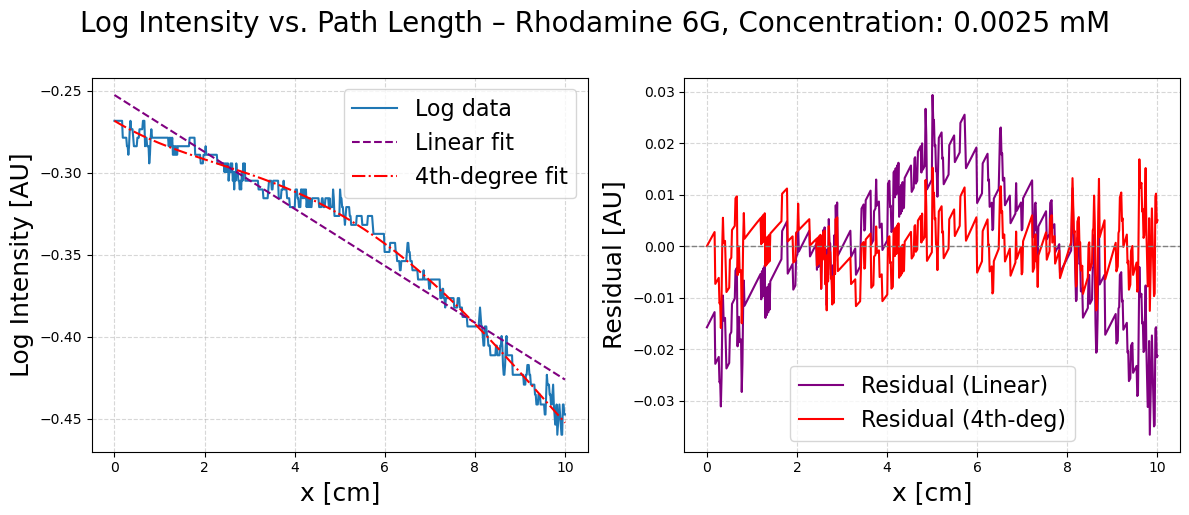

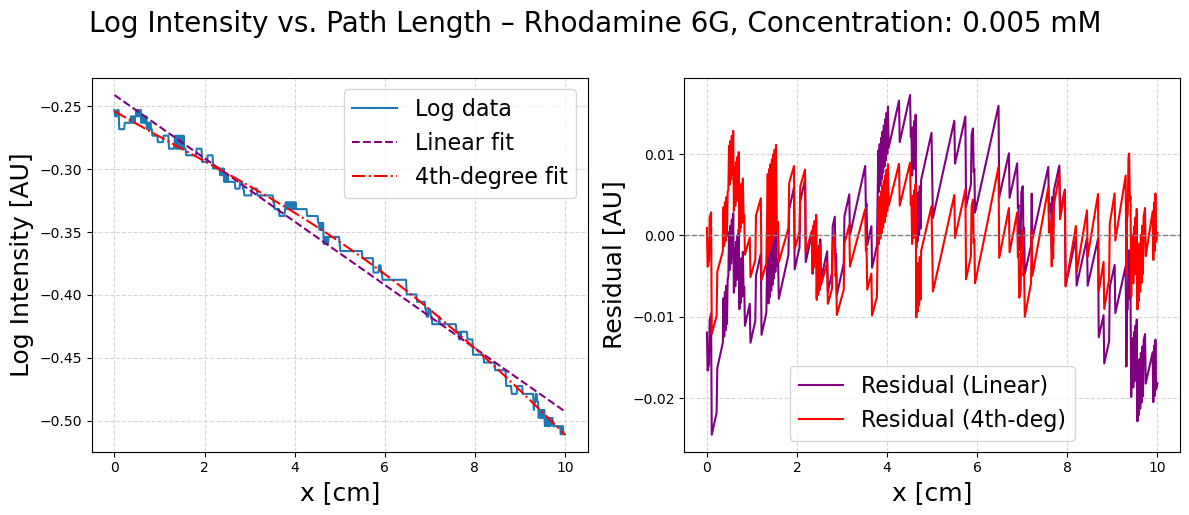

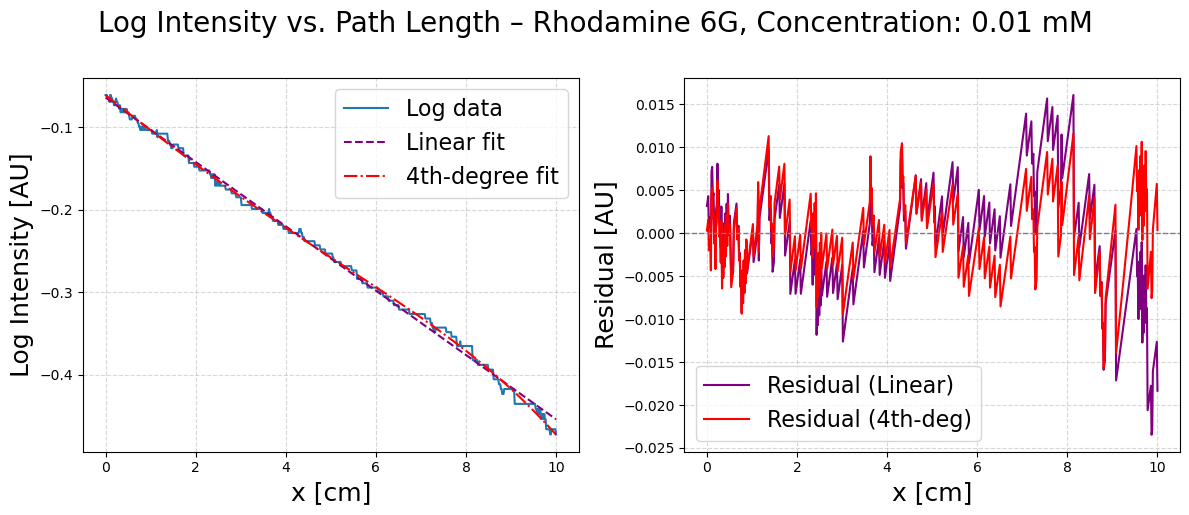

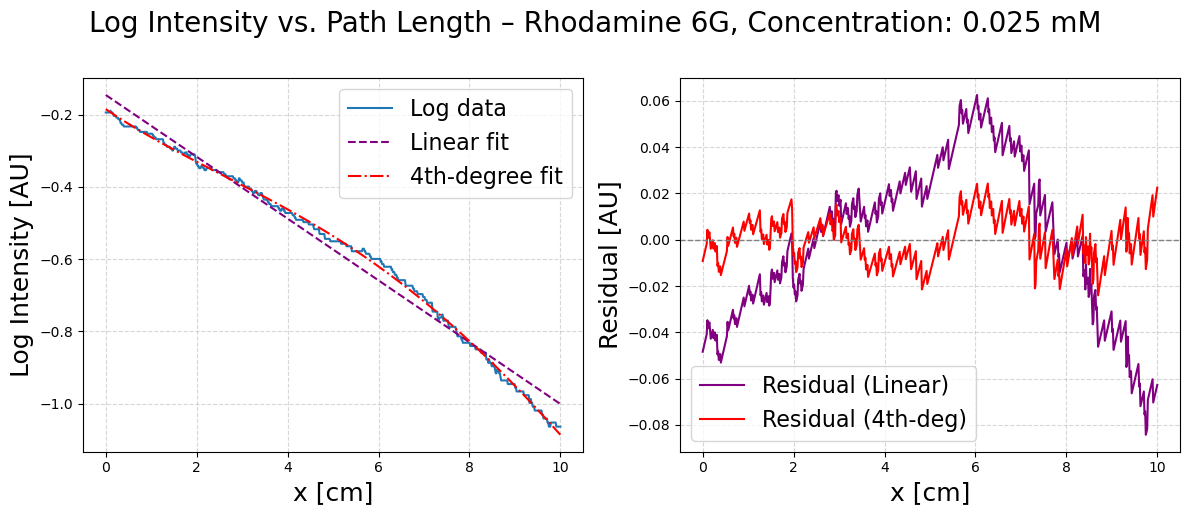

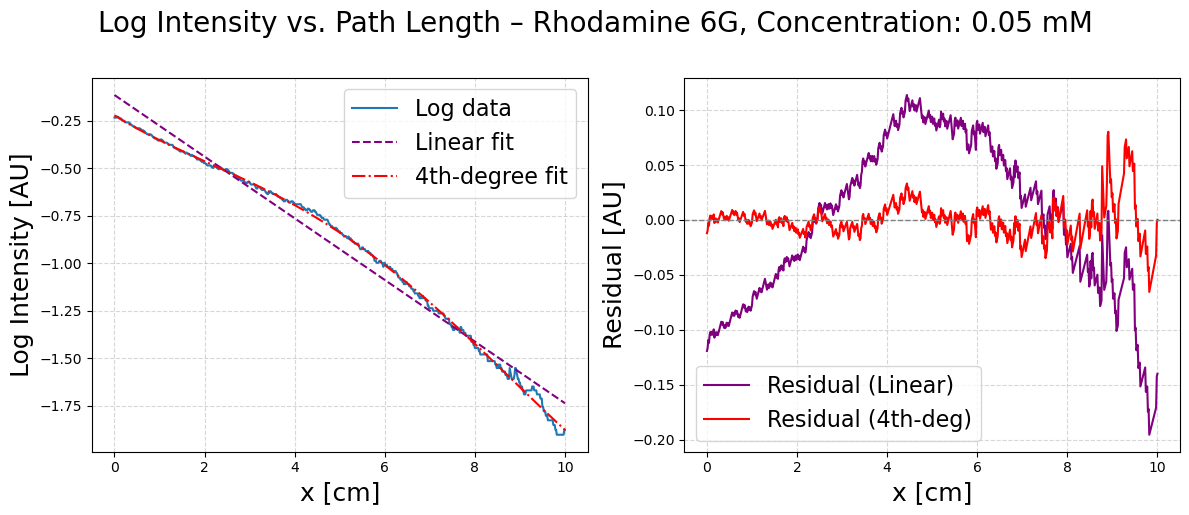

In [44]:
# Yellow

%matplotlib inline

import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ───── Folder & file‐list ───────────────────────────────────────────
folder = 'Part 2/yellow'   # adjust if needed
patterns = [os.path.join(folder, 'gconc*.jpeg'),
            os.path.join(folder, 'gconc*.jpg')]
files = sorted(sum((glob.glob(p) for p in patterns), []))

# ───── Provide concentrations here ───────────────────────────────────
# Define this dictionary according to your filename structure

# ───── Process each image ───────────────────────────────────────────
for path in files:
    conc = concs[int(os.path.basename(path)[5:-5])]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    G   = img[:,:,1].astype(np.float64)/255.0
    B   = img[:,:,0].astype(np.float64)/255.0

    # Brightest row & left-edge x0
    y    = np.argmax(G.sum(axis=1))
    row  = G[y,:]
    x0   = 10 + np.argmax(row[10:300])

    # Right-edge by max blue in x0+600…x0+900
    start = x0+600
    end   = min(x0+900, B.shape[1])
    blue_region = B[y, start:end]
    x1 = start + np.argmax(blue_region) if blue_region.size else min(x0+700, G.shape[1]-1)

    # Log-intensity profile
    Av = np.log(np.clip(row[x0+20:x1-50], 1e-6, None))
    x_cm = np.linspace(0, 10, len(Av))

    # Fits & residuals
    p1, p4 = np.polyfit(x_cm, Av, 1), np.polyfit(x_cm, Av, 4)
    fit1, fit4 = np.polyval(p1, x_cm), np.polyval(p4, x_cm)
    resid1, resid4 = Av - fit1, Av - fit4

    # Plot: Data+Fits & Residuals
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Data + fits
    ax1.plot(x_cm, Av, label='Log data')
    line1, = ax1.plot(x_cm, fit1, '--', label='Linear fit', color='purple')
    line4, = ax1.plot(x_cm, fit4, '-.', label='4th‑degree fit', color='red')
    ax1.set_xlabel('x [cm]', fontsize=18)
    ax1.set_ylabel('Log Intensity [AU]', fontsize=18)
    ax1.legend(fontsize=16)
    ax1.grid(True, ls='--', alpha=0.5)

    # Residuals
    ax2.plot(x_cm, resid1, label='Residual (Linear)', color=line1.get_color())
    ax2.plot(x_cm, resid4, label='Residual (4th‑deg)', color=line4.get_color())
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax2.set_xlabel('x [cm]', fontsize=18)
    ax2.set_ylabel('Residual [AU]', fontsize=18)
    ax2.legend(fontsize=16)
    ax2.grid(True, ls='--', alpha=0.5)

    title = f"Log Intensity vs. Path Length – Rhodamine 6G, Concentration: {conc} mM"
    fig.suptitle(title, y=1.02, fontsize=20)

    plt.tight_layout()
    plt.show()


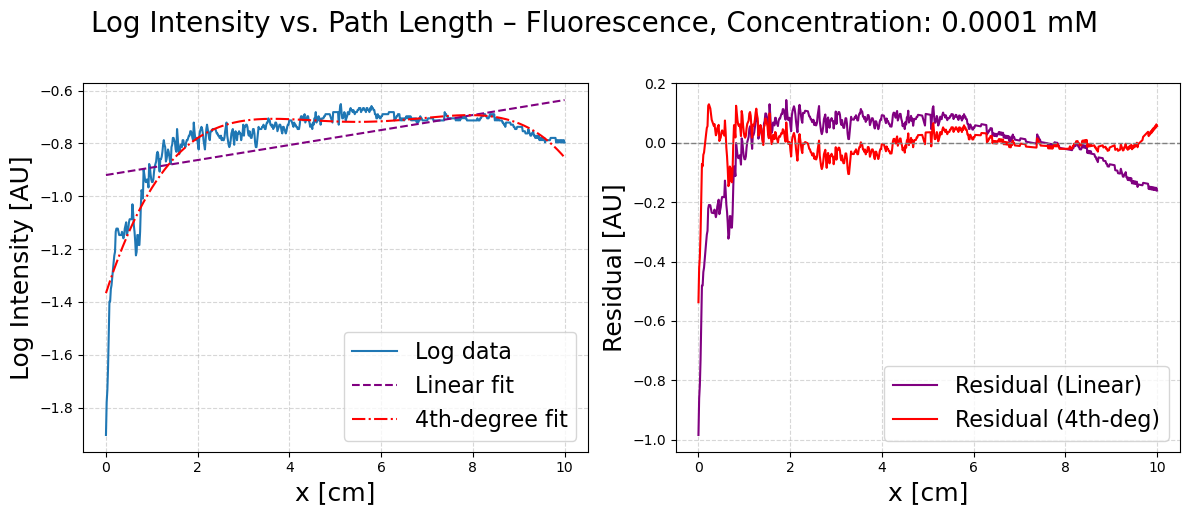

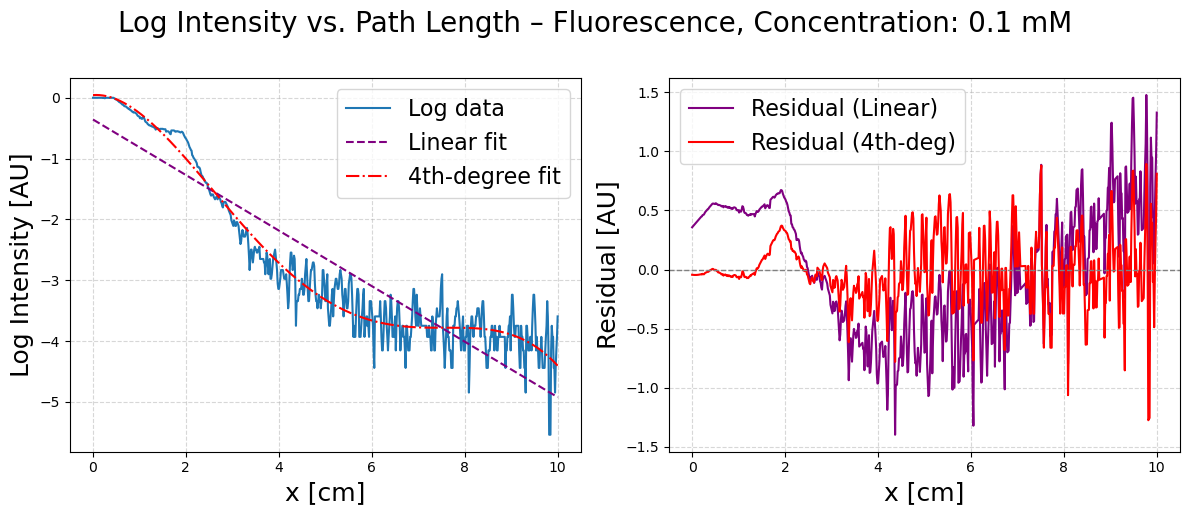

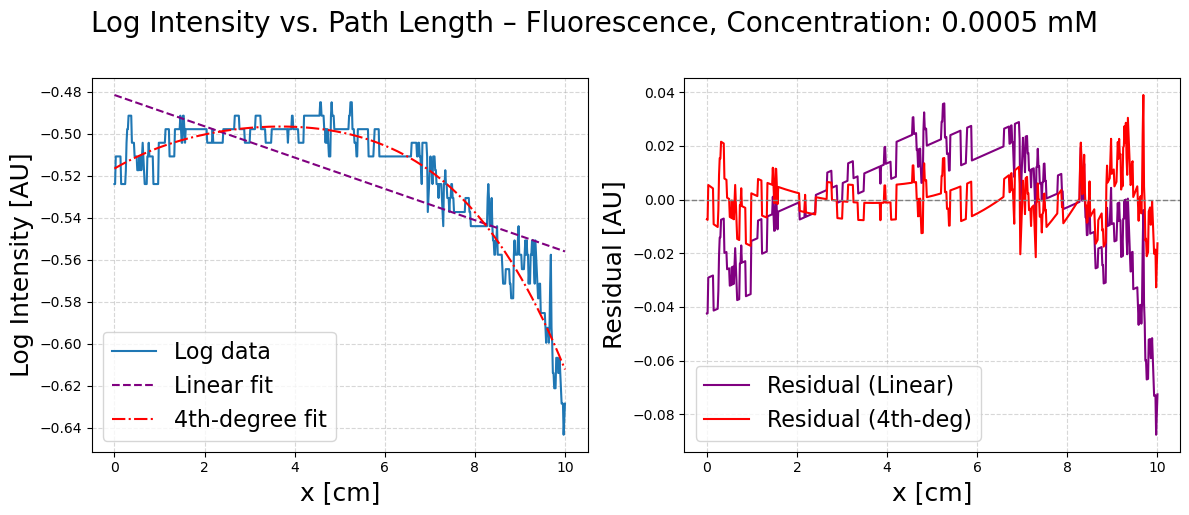

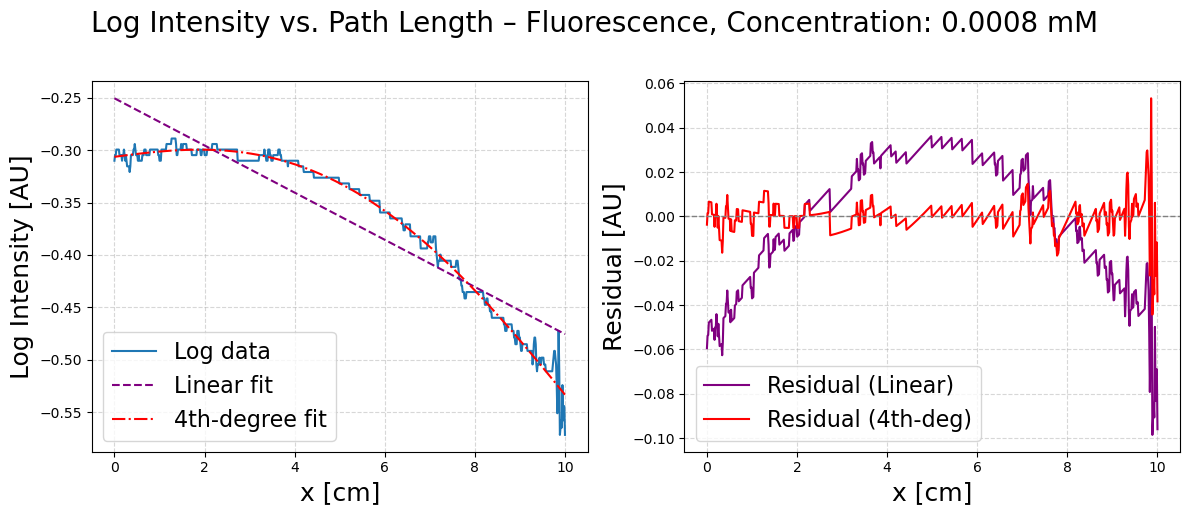

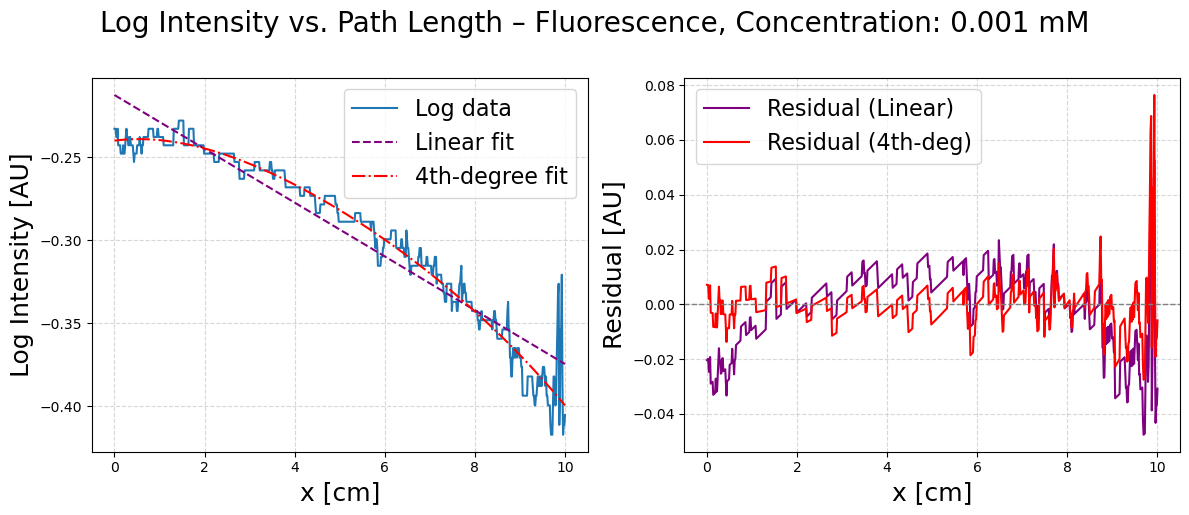

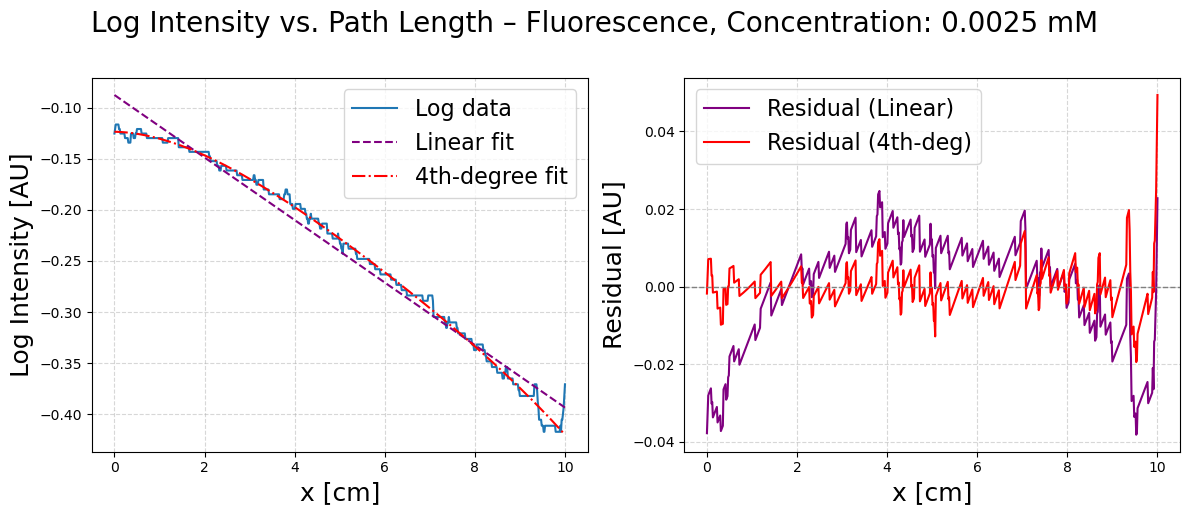

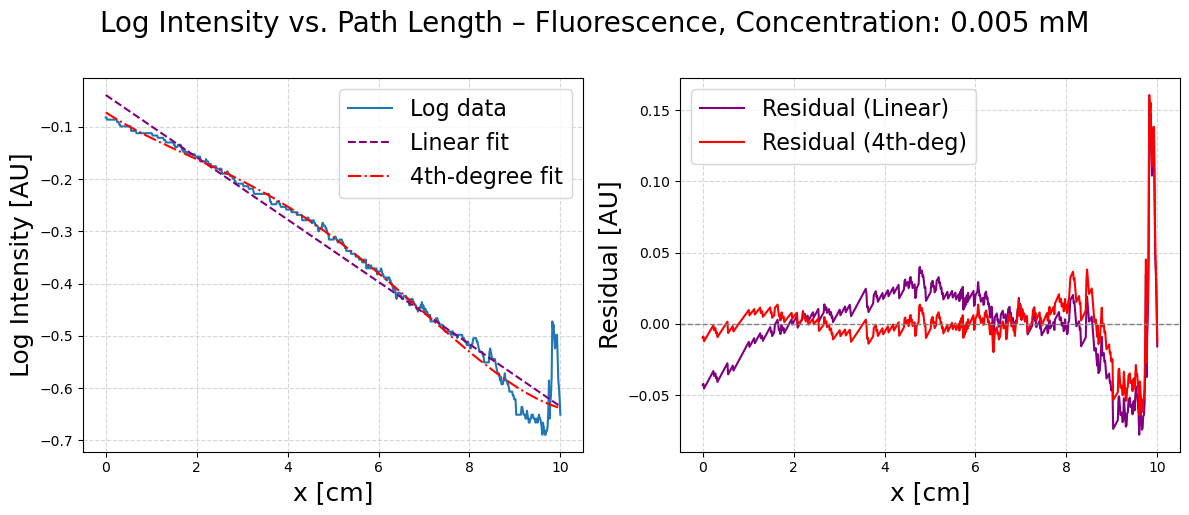

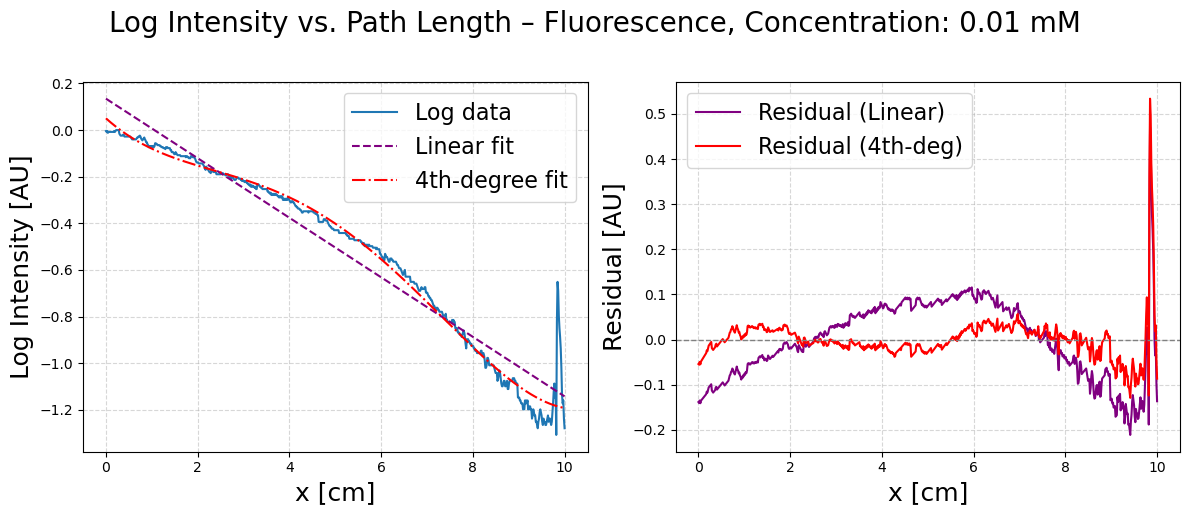

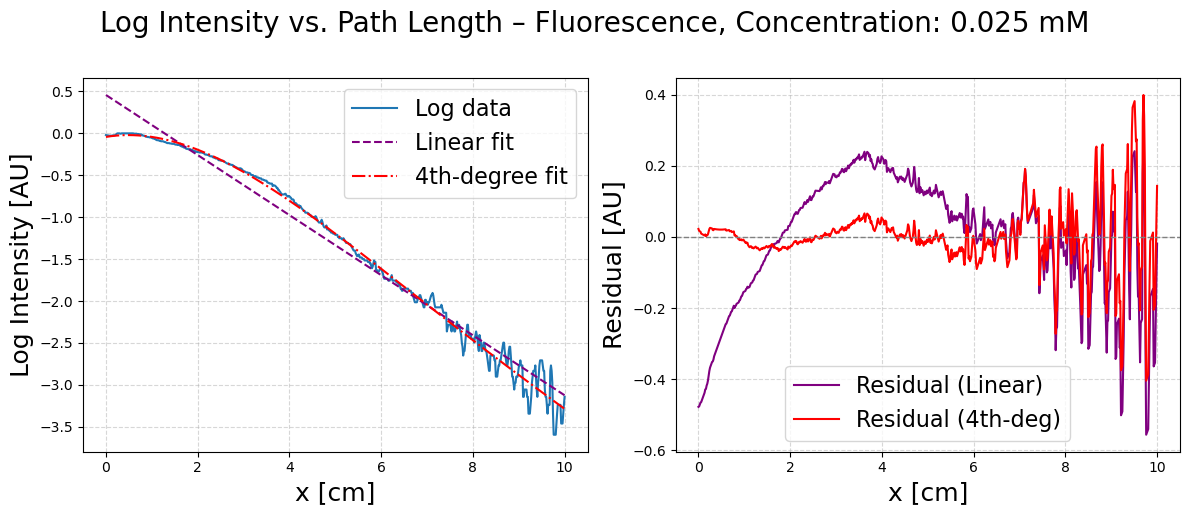

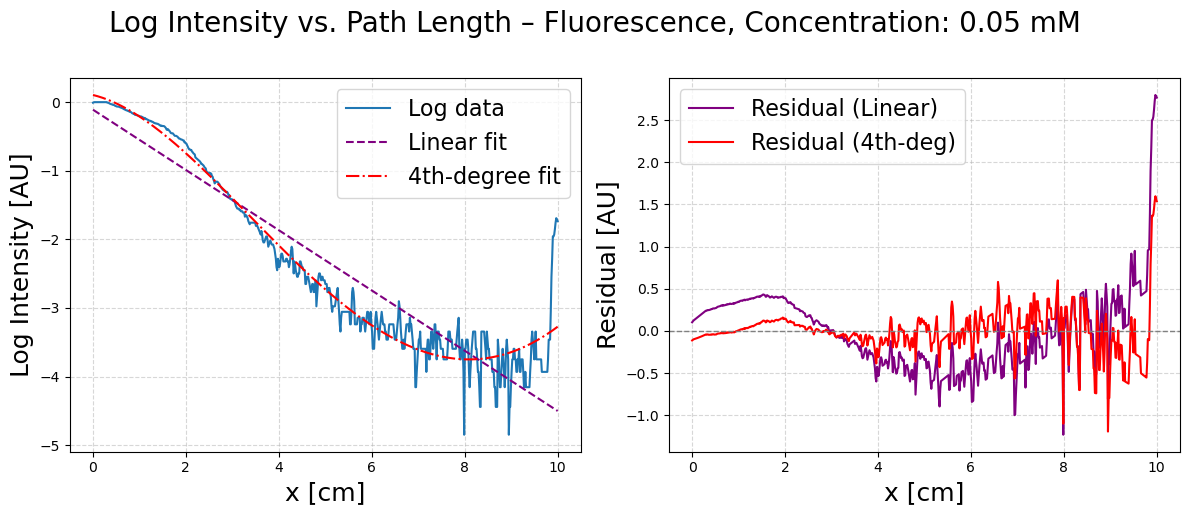

In [51]:
# Yellow

%matplotlib inline

import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ───── Folder & file‐list ───────────────────────────────────────────
folder = 'Part 2/green'   # adjust if needed
patterns = [os.path.join(folder, 'gconc*.jpeg'),
            os.path.join(folder, 'gconc*.jpg')]
files = sorted(sum((glob.glob(p) for p in patterns), []))

# ───── Provide concentrations here ───────────────────────────────────
# Define this dictionary according to your filename structure

# ───── Process each image ───────────────────────────────────────────
for path in files:
    conc = concs[int(os.path.basename(path)[5:-5])]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    G   = img[:,:,1].astype(np.float64)/255.0
    B   = img[:,:,0].astype(np.float64)/255.0

    # Brightest row & left-edge x0
    y    = np.argmax(G.sum(axis=1))
    row  = G[y,:]
    x0   = 10 + np.argmax(row[10:300])

    # Right-edge by max blue in x0+600…x0+900
    start = x0+600
    end   = min(x0+900, B.shape[1])
    blue_region = B[y, start:end]
    x1 = start + np.argmax(blue_region) if blue_region.size else min(x0+700, G.shape[1]-1)

    # Log-intensity profile
    Av = np.log(np.clip(row[x0+20:x1-50], 1e-6, None))
    x_cm = np.linspace(0, 10, len(Av))

    # Fits & residuals
    p1, p4 = np.polyfit(x_cm, Av, 1), np.polyfit(x_cm, Av, 4)
    fit1, fit4 = np.polyval(p1, x_cm), np.polyval(p4, x_cm)
    resid1, resid4 = Av - fit1, Av - fit4

    # Plot: Data+Fits & Residuals
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Data + fits
    ax1.plot(x_cm, Av, label='Log data')
    line1, = ax1.plot(x_cm, fit1, '--', label='Linear fit', color='purple')
    line4, = ax1.plot(x_cm, fit4, '-.', label='4th‑degree fit', color='red')
    ax1.set_xlabel('x [cm]', fontsize=18)
    ax1.set_ylabel('Log Intensity [AU]', fontsize=18)
    ax1.legend(fontsize=16)
    ax1.grid(True, ls='--', alpha=0.5)

    # Residuals
    ax2.plot(x_cm, resid1, label='Residual (Linear)', color=line1.get_color())
    ax2.plot(x_cm, resid4, label='Residual (4th‑deg)', color=line4.get_color())
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax2.set_xlabel('x [cm]', fontsize=18)
    ax2.set_ylabel('Residual [AU]', fontsize=18)
    ax2.legend(fontsize=16)
    ax2.grid(True, ls='--', alpha=0.5)

    title = f"Log Intensity vs. Path Length – Fluorescence, Concentration: {conc} mM"
    fig.suptitle(title, y=1.02, fontsize=20)

    plt.tight_layout()
    plt.show()


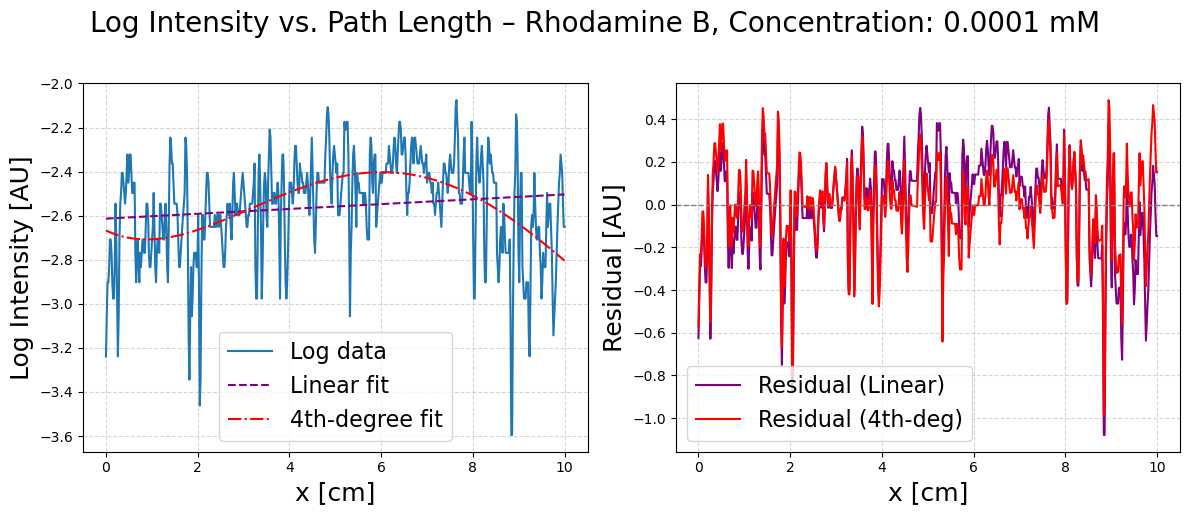

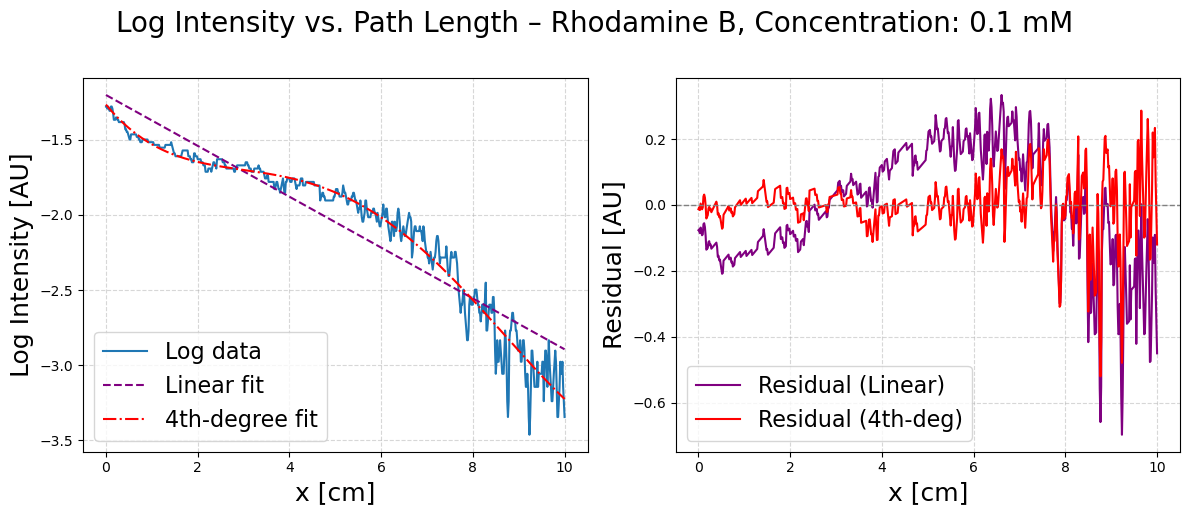

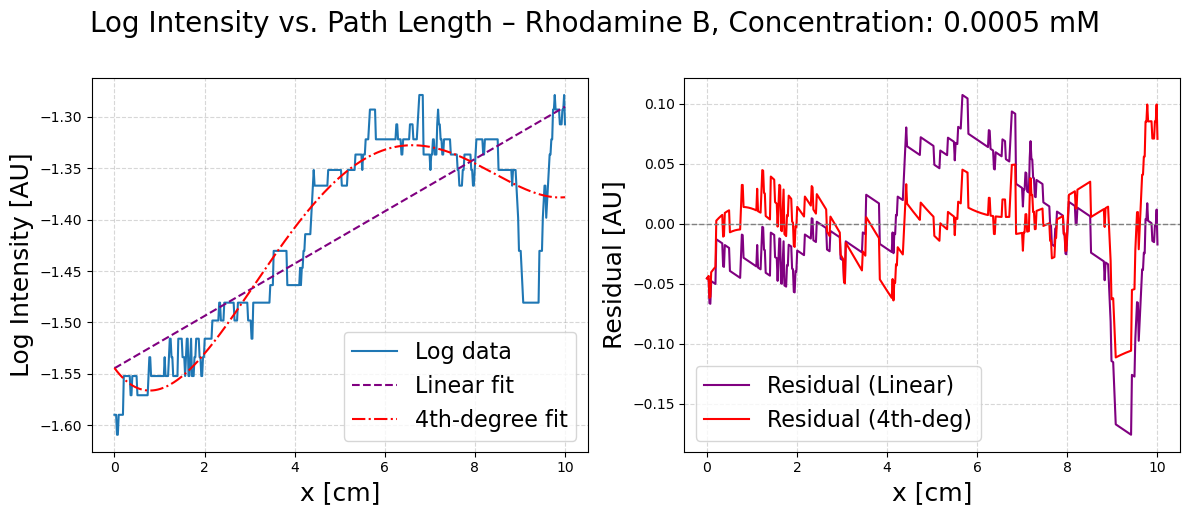

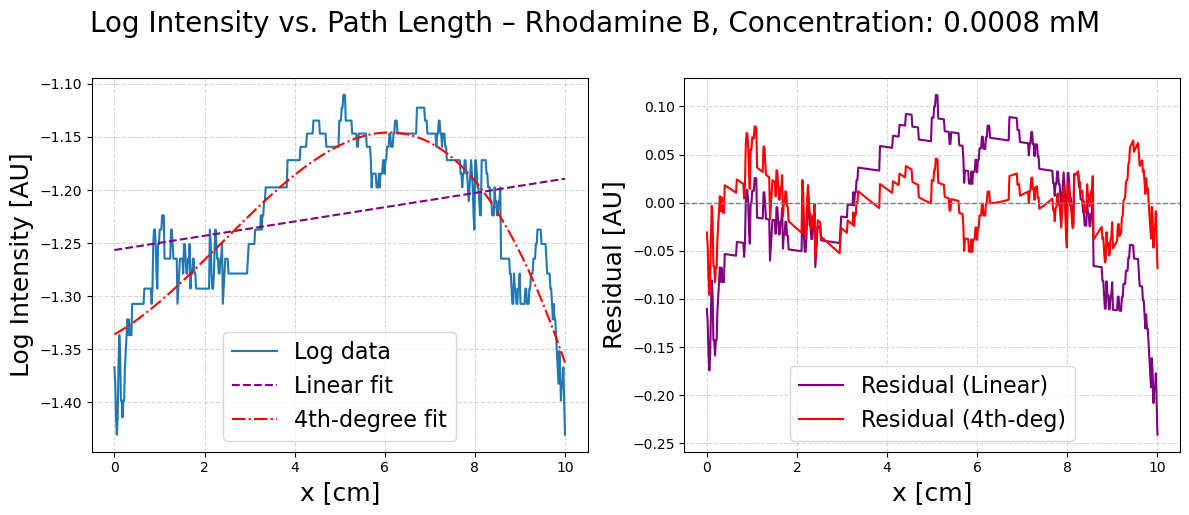

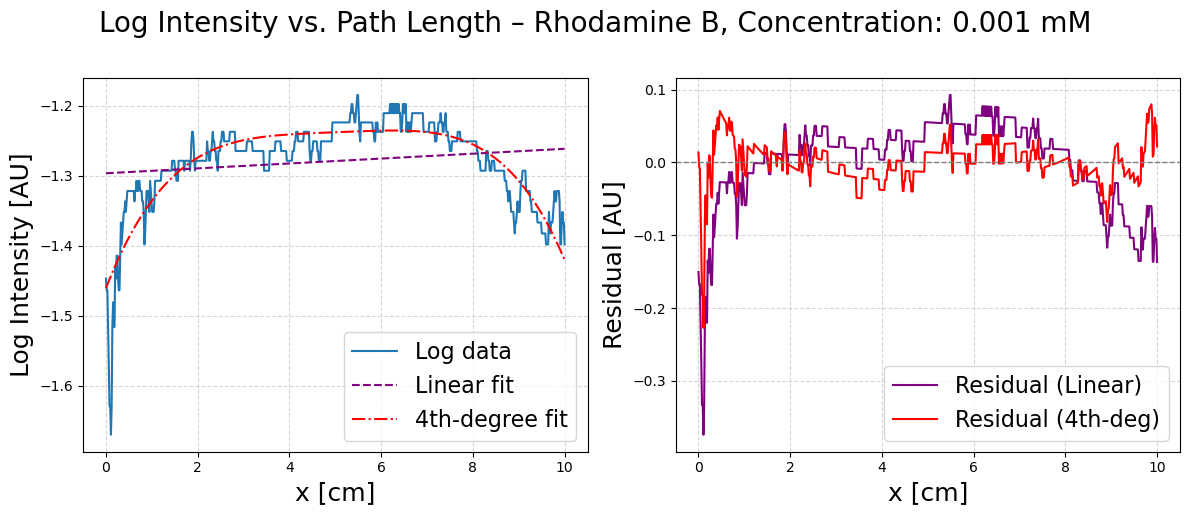

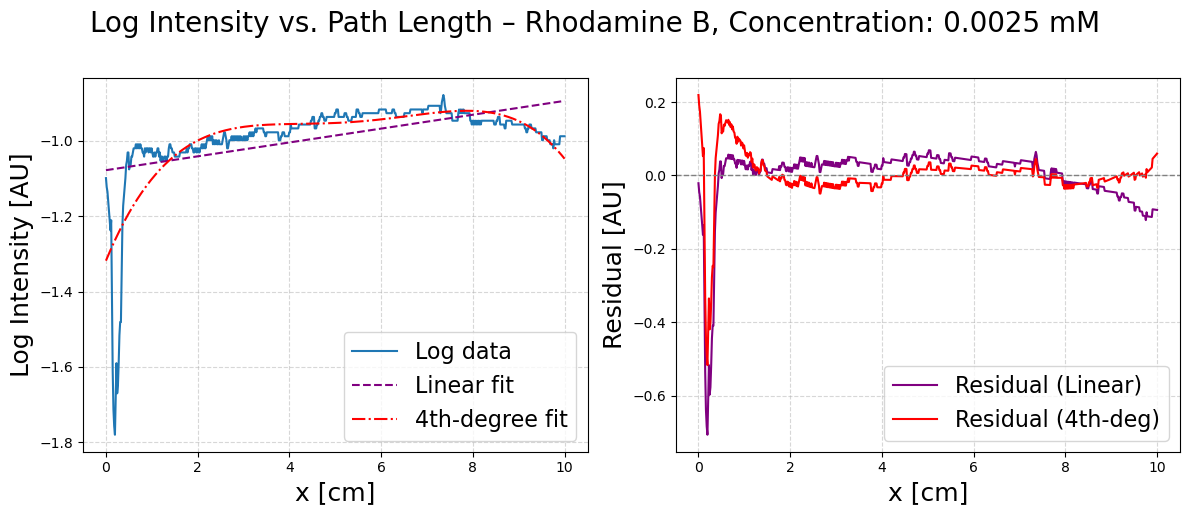

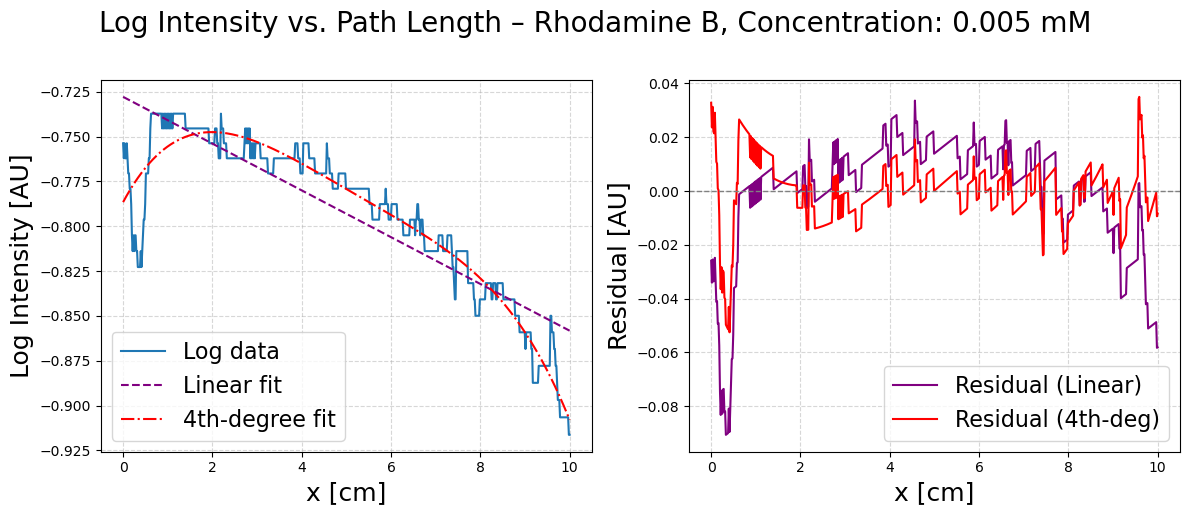

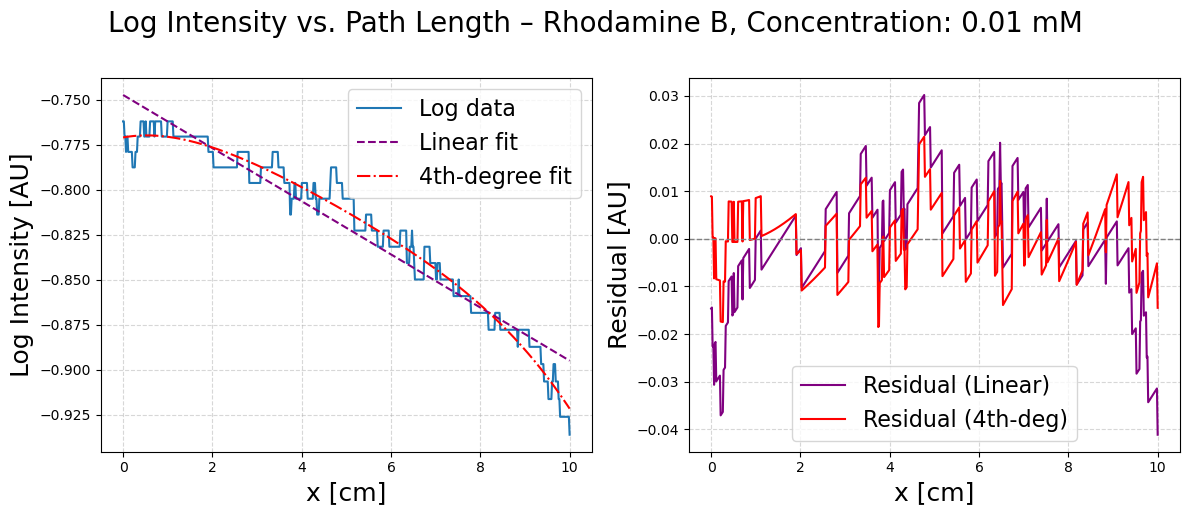

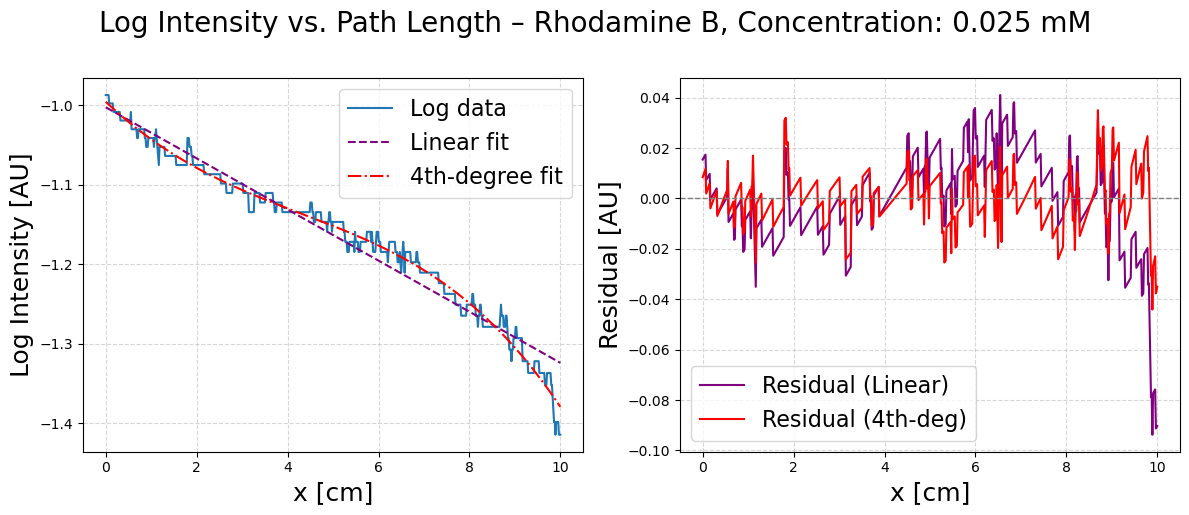

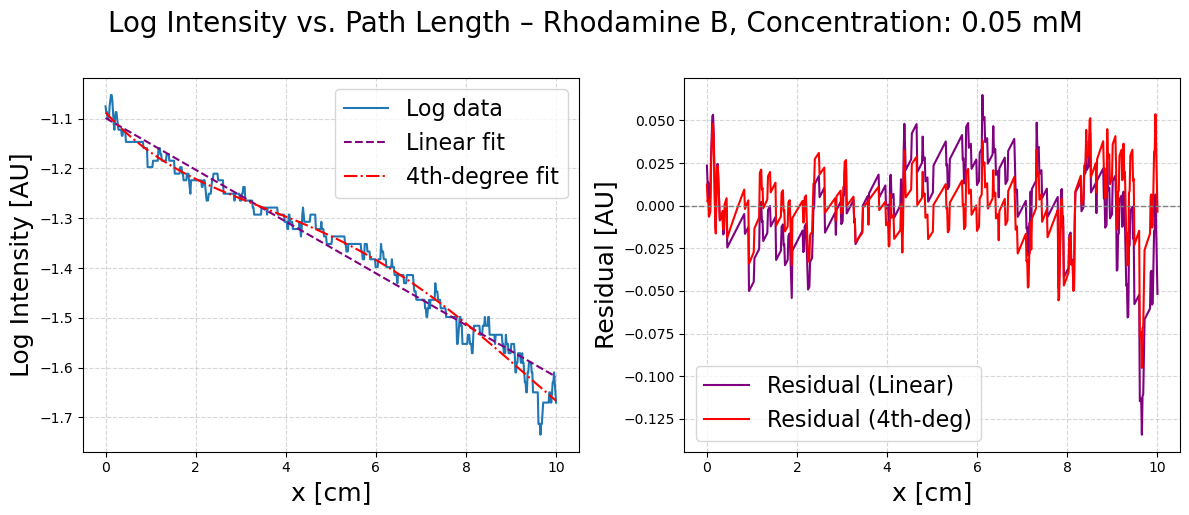

In [52]:
# Yellow

%matplotlib inline

import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ───── Folder & file‐list ───────────────────────────────────────────
folder = 'Part 2/red'   # adjust if needed
patterns = [os.path.join(folder, 'rconc*.jpeg'),
            os.path.join(folder, 'rconc*.jpg')]
files = sorted(sum((glob.glob(p) for p in patterns), []))

# ───── Provide concentrations here ───────────────────────────────────
# Define this dictionary according to your filename structure

# ───── Process each image ───────────────────────────────────────────
for path in files:
    conc = concs[int(os.path.basename(path)[5:-5])]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    G   = img[:,:,1].astype(np.float64)/255.0
    B   = img[:,:,0].astype(np.float64)/255.0

    # Brightest row & left-edge x0
    y    = np.argmax(G.sum(axis=1))
    row  = G[y,:]
    x0   = 10 + np.argmax(row[10:300])

    # Right-edge by max blue in x0+600…x0+900
    start = x0+600
    end   = min(x0+900, B.shape[1])
    blue_region = B[y, start:end]
    x1 = start + np.argmax(blue_region) if blue_region.size else min(x0+700, G.shape[1]-1)

    # Log-intensity profile
    Av = np.log(np.clip(row[x0+20:x1-50], 1e-6, None))
    x_cm = np.linspace(0, 10, len(Av))

    # Fits & residuals
    p1, p4 = np.polyfit(x_cm, Av, 1), np.polyfit(x_cm, Av, 4)
    fit1, fit4 = np.polyval(p1, x_cm), np.polyval(p4, x_cm)
    resid1, resid4 = Av - fit1, Av - fit4

    # Plot: Data+Fits & Residuals
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Data + fits
    ax1.plot(x_cm, Av, label='Log data')
    line1, = ax1.plot(x_cm, fit1, '--', label='Linear fit', color='purple')
    line4, = ax1.plot(x_cm, fit4, '-.', label='4th‑degree fit', color='red')
    ax1.set_xlabel('x [cm]', fontsize=18)
    ax1.set_ylabel('Log Intensity [AU]', fontsize=18)
    ax1.legend(fontsize=16)
    ax1.grid(True, ls='--', alpha=0.5)

    # Residuals
    ax2.plot(x_cm, resid1, label='Residual (Linear)', color=line1.get_color())
    ax2.plot(x_cm, resid4, label='Residual (4th‑deg)', color=line4.get_color())
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax2.set_xlabel('x [cm]', fontsize=18)
    ax2.set_ylabel('Residual [AU]', fontsize=18)
    ax2.legend(fontsize=16)
    ax2.grid(True, ls='--', alpha=0.5)

    title = f"Log Intensity vs. Path Length – Rhodamine B, Concentration: {conc} mM"
    fig.suptitle(title, y=1.02, fontsize=20)

    plt.tight_layout()
    plt.show()


# Part 3: excitons

In [53]:
import os
import re
import pandas as pd

# Directory containing the angle‐named .ods files
angle_dir = "Part3"

# List to hold [angle, DataFrame]
data = []

for fname in sorted(os.listdir(angle_dir)):
    if fname.endswith(".ods"):
        # Extract the angle (integer or float) from the filename (e.g. "-2.ods")
        m = re.match(r"(-?\d+\.?\d*)\.ods$", fname)
        if not m:
            continue
        angle = float(m.group(1))
        
        # Load the sheet into a DataFrame
        path = os.path.join(angle_dir, fname)
        df = pd.read_excel(path, engine="odf", sheet_name=0)
        
        data.append([angle, df])

# Sanity check
print(f"Loaded {len(data)} angle files:")
for angle, df in data:
    print(f"  angle = {angle}, rows = {len(df)}")


Loaded 21 angle files:
  angle = -10.0, rows = 3648
  angle = -12.0, rows = 3648
  angle = -14.0, rows = 3648
  angle = -16.0, rows = 3648
  angle = -18.0, rows = 3648
  angle = -2.0, rows = 3648
  angle = -20.0, rows = 3648
  angle = -4.0, rows = 3648
  angle = -6.0, rows = 3648
  angle = -8.0, rows = 3648
  angle = 0.0, rows = 3648
  angle = 10.0, rows = 3648
  angle = 12.0, rows = 3648
  angle = 14.0, rows = 3648
  angle = 16.0, rows = 3648
  angle = 18.0, rows = 3648
  angle = 2.0, rows = 3648
  angle = 20.0, rows = 3648
  angle = 4.0, rows = 3648
  angle = 6.0, rows = 3648
  angle = 8.0, rows = 3648


In [54]:
import copy
data3 = copy.deepcopy(data)
for i in range(21):
    data3[i][1]['wavel']= data3[i][1]['X [nm (air)]']
    data3[i][1]['I']= data3[i][1]['Y [Intensity]']
    data3[i][1] = data3[i][1][['wavel', 'I']]

In [97]:
data3

[[-10.0,
             wavel         I
  0     321.590820  0.004593
  1     321.698334  0.002477
  2     321.805878  0.004317
  3     321.913422  0.011157
  4     322.020966  0.007034
  ...          ...       ...
  3643  744.272034 -0.055035
  3644  744.392334 -0.057600
  3645  744.512573 -0.057580
  3646  744.632812 -0.057660
  3647  744.753052 -0.057988
  
  [3648 rows x 2 columns]],
 [-12.0,
             wavel         I
  0     321.590820  0.005222
  1     321.698334  0.001886
  2     321.805878  0.004296
  3     321.913422  0.010943
  4     322.020966  0.007665
  ...          ...       ...
  3643  744.272034 -0.055996
  3644  744.392334 -0.057491
  3645  744.512573 -0.058378
  3646  744.632812 -0.058902
  3647  744.753052 -0.058631
  
  [3648 rows x 2 columns]],
 [-14.0,
             wavel         I
  0     321.590820  0.005560
  1     321.698334  0.002556
  2     321.805878  0.004232
  3     321.913422  0.013449
  4     322.020966  0.008749
  ...          ...       ...
  3643  744.


Angle -10.0°
  Gauss1: μ₁ = 529.87 ± 0.12, σ₁ = 12.98
  Gauss2: μ₂ = 570.39 ± 0.08, σ₂ = 14.39
  BG: p0–p3 = [-1.7610722943996376e-06, 0.002974499012177543, -1.6676270018109356, 310.4787735343412]



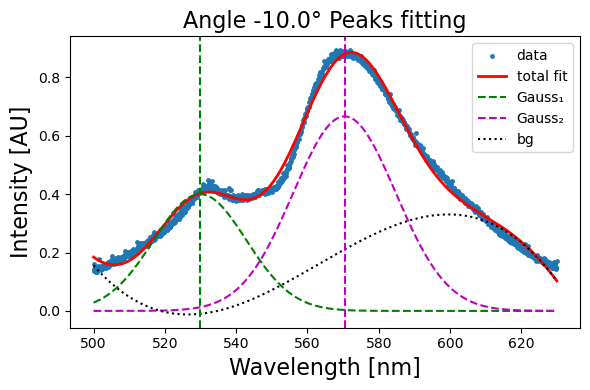


Angle -12.0°
  Gauss1: μ₁ = 529.80 ± 0.12, σ₁ = 12.93
  Gauss2: μ₂ = 570.16 ± 0.08, σ₂ = 14.39
  BG: p0–p3 = [-1.7249288415517961e-06, 0.002913666282292806, -1.6336821544349396, 304.19769906618956]



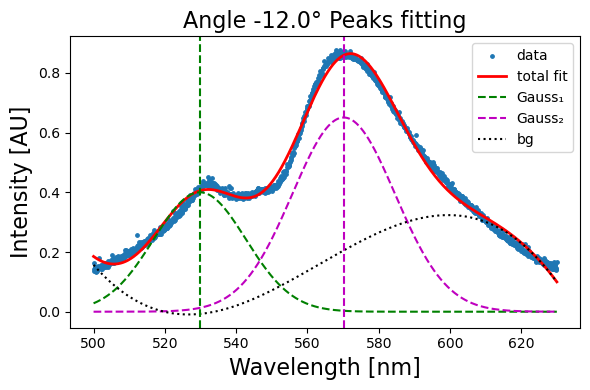


Angle -14.0°
  Gauss1: μ₁ = 529.80 ± 0.11, σ₁ = 11.87
  Gauss2: μ₂ = 570.14 ± 0.07, σ₂ = 14.28
  BG: p0–p3 = [-1.672412799827989e-06, 0.002809418300593816, -1.5665940371498004, 290.2001478435615]



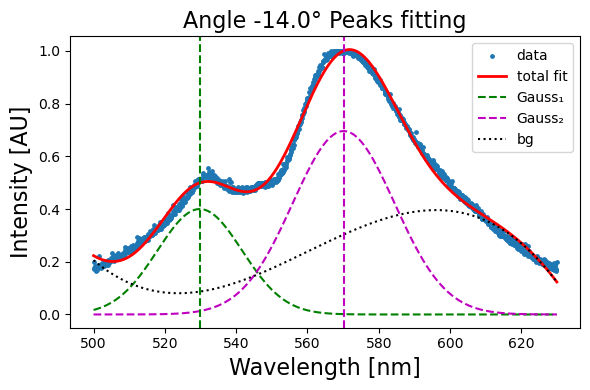


Angle -16.0°
  Gauss1: μ₁ = 529.71 ± 0.11, σ₁ = 11.75
  Gauss2: μ₂ = 569.85 ± 0.07, σ₂ = 14.17
  BG: p0–p3 = [-1.607000256583899e-06, 0.002697671854504728, -1.5032833801845031, 278.3087786412419]



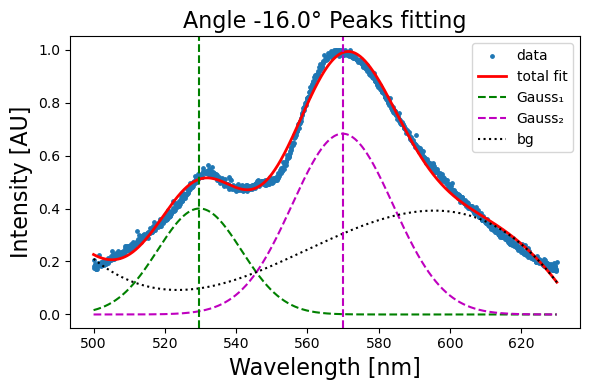


Angle -18.0°
  Gauss1: μ₁ = 529.51 ± 0.11, σ₁ = 11.61
  Gauss2: μ₂ = 569.46 ± 0.07, σ₂ = 14.11
  BG: p0–p3 = [-1.5235937459721954e-06, 0.0025561104883118574, -1.4236183465708745, 263.4461931080949]



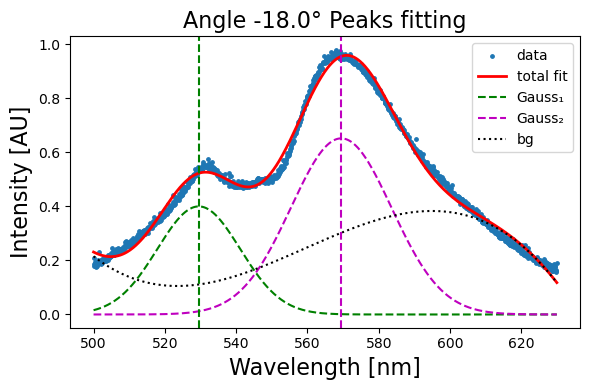


Angle -2.0°
  Gauss1: μ₁ = 529.03 ± 0.12, σ₁ = 13.67
  Gauss2: μ₂ = 570.50 ± 0.08, σ₂ = 15.23
  BG: p0–p3 = [-1.8426897419860591e-06, 0.00311711276329972, -1.7500010379566584, 326.1984641472563]



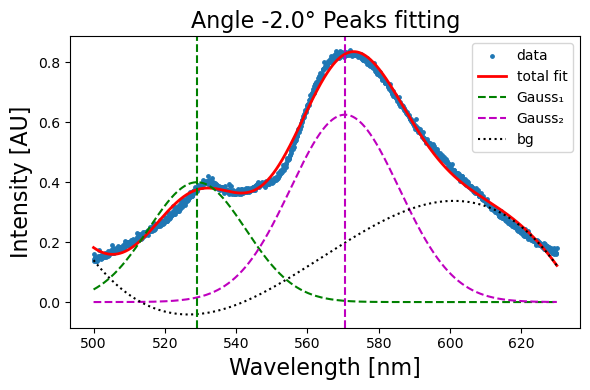


Angle -20.0°
  Gauss1: μ₁ = 529.39 ± 0.10, σ₁ = 11.57
  Gauss2: μ₂ = 569.11 ± 0.07, σ₂ = 14.10
  BG: p0–p3 = [-1.4676072758864725e-06, 0.002462932338043053, -1.3721838208553796, 254.02251649441052]



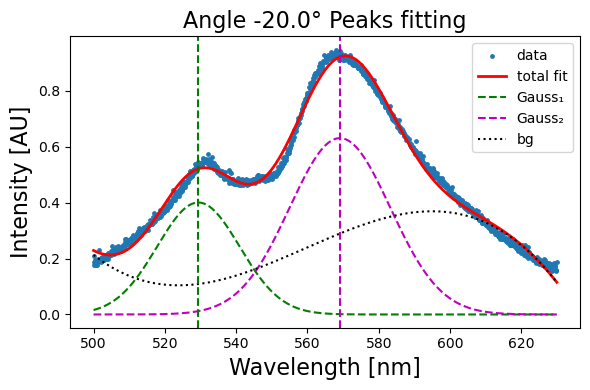


Angle -4.0°
  Gauss1: μ₁ = 564.57 ± 0.35, σ₁ = 11.64
  Gauss2: μ₂ = 598.26 ± 0.30, σ₂ = 19.26
  BG: p0–p3 = [3.043631117130686e-06, -0.005149370804084213, 2.8895653006823405, -537.6355024878736]



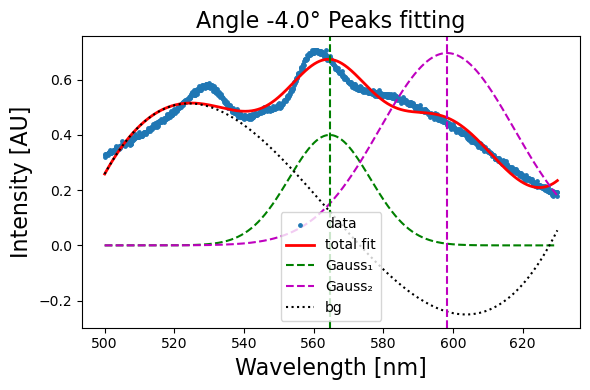


Angle -6.0°
  Gauss1: μ₁ = 529.49 ± 0.12, σ₁ = 12.84
  Gauss2: μ₂ = 570.90 ± 0.07, σ₂ = 14.61
  BG: p0–p3 = [-1.923478879696971e-06, 0.003242112860989545, -1.813628955691046, 336.9011598525637]



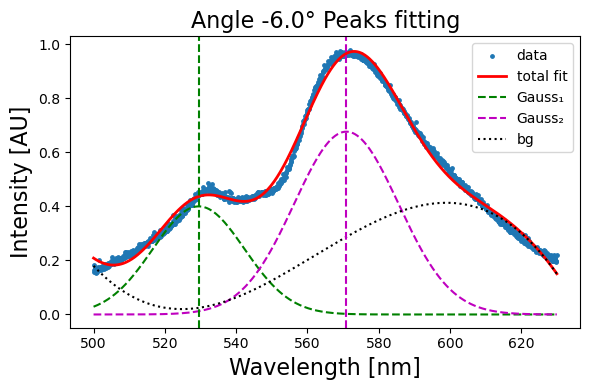


Angle -8.0°
  Gauss1: μ₁ = 529.62 ± 0.12, σ₁ = 13.22
  Gauss2: μ₂ = 570.60 ± 0.08, σ₂ = 14.34
  BG: p0–p3 = [-1.917205337259521e-06, 0.003235854118142861, -1.8123926920003053, 337.047201226716]



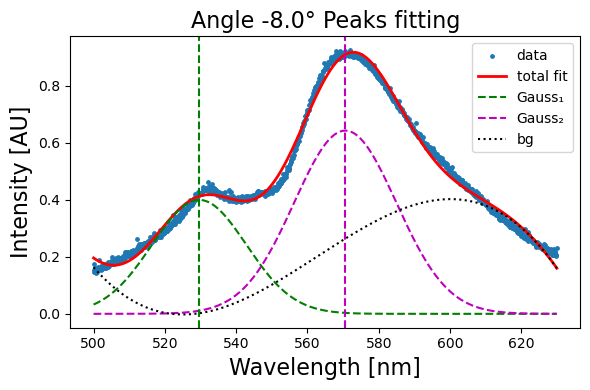


Angle +0.0°
  Gauss1: μ₁ = 529.78 ± 0.13, σ₁ = 14.21
  Gauss2: μ₂ = 570.41 ± 0.09, σ₂ = 14.57
  BG: p0–p3 = [-1.7912429798521423e-06, 0.003037768800125088, -1.7098353838304954, 319.4870545290551]



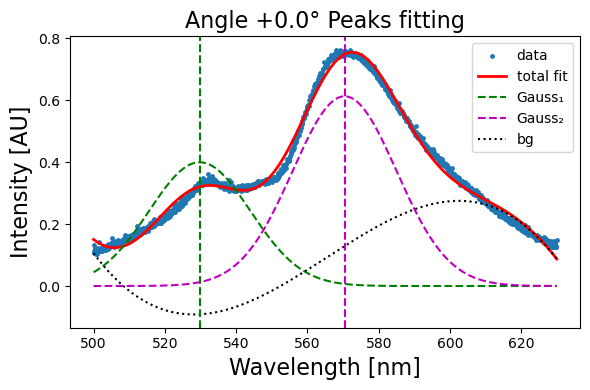


Angle +10.0°
  Gauss1: μ₁ = 529.29 ± 0.13, σ₁ = 13.51
  Gauss2: μ₂ = 568.74 ± 0.10, σ₂ = 14.68
  BG: p0–p3 = [-1.665349774928691e-06, 0.0028227777120587083, -1.5881000437915103, 296.646761206006]



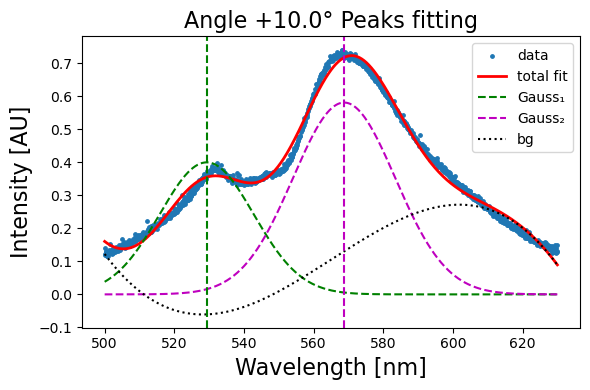


Angle +12.0°
  Gauss1: μ₁ = 529.15 ± 0.13, σ₁ = 13.28
  Gauss2: μ₂ = 568.45 ± 0.10, σ₂ = 14.75
  BG: p0–p3 = [-1.630409680505231e-06, 0.0027626248174051726, -1.5537709405492053, 290.16092938144476]



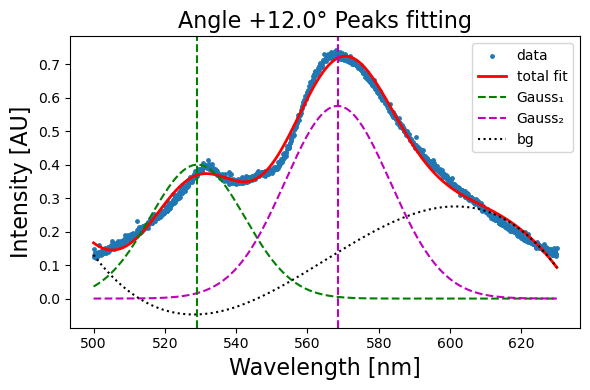


Angle +14.0°
  Gauss1: μ₁ = 528.90 ± 0.13, σ₁ = 13.12
  Gauss2: μ₂ = 567.91 ± 0.10, σ₂ = 14.82
  BG: p0–p3 = [-1.5790154190511737e-06, 0.002675256686043812, -1.5044976935333187, 280.9465609693733]



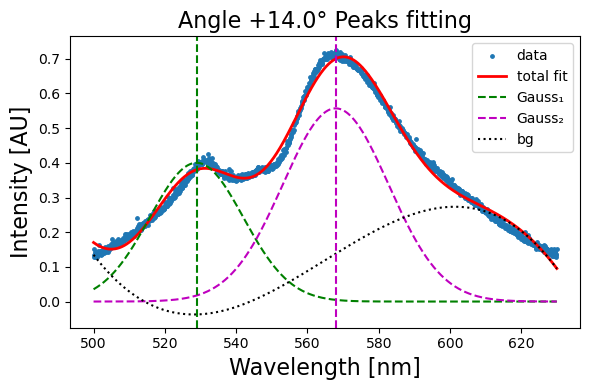


Angle +16.0°
  Gauss1: μ₁ = 528.59 ± 0.12, σ₁ = 12.88
  Gauss2: μ₂ = 567.34 ± 0.10, σ₂ = 14.91
  BG: p0–p3 = [-1.5191578707135637e-06, 0.002573117416223323, -1.446693014241332, 270.1050557827686]



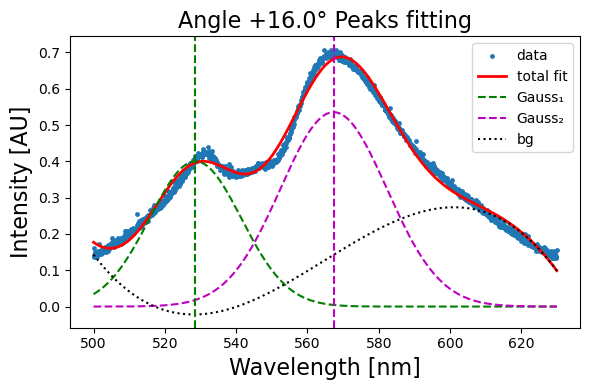


Angle +18.0°
  Gauss1: μ₁ = 528.23 ± 0.12, σ₁ = 12.65
  Gauss2: μ₂ = 566.78 ± 0.10, σ₂ = 15.04
  BG: p0–p3 = [-1.4753781059698449e-06, 0.0024979057150800897, -1.4038613860828946, 262.02721350150256]



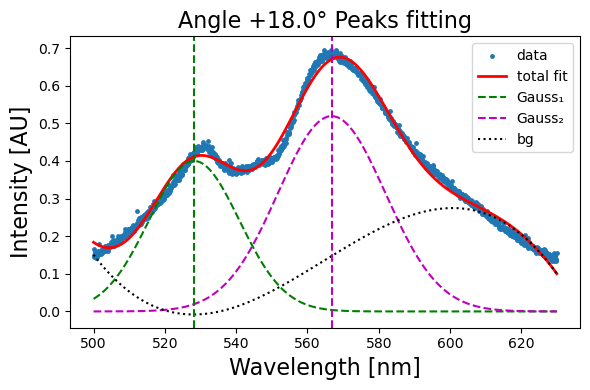


Angle +2.0°
  Gauss1: μ₁ = 529.73 ± 0.13, σ₁ = 14.18
  Gauss2: μ₂ = 570.22 ± 0.10, σ₂ = 14.59
  BG: p0–p3 = [-1.7786415858195069e-06, 0.0030165483328380995, -1.6979849383791212, 317.2901311785791]



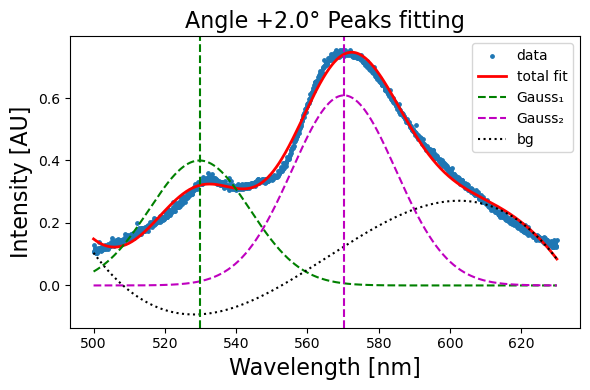


Angle +20.0°
  Gauss1: μ₁ = 527.78 ± 0.11, σ₁ = 12.52
  Gauss2: μ₂ = 566.25 ± 0.10, σ₂ = 15.18
  BG: p0–p3 = [-1.4195822516724173e-06, 0.0024035702878183194, -1.3509518906329219, 252.18979380494338]



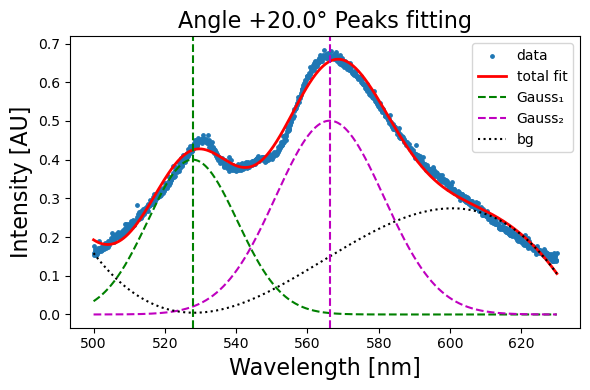


Angle +4.0°
  Gauss1: μ₁ = 529.68 ± 0.13, σ₁ = 14.06
  Gauss2: μ₂ = 569.99 ± 0.10, σ₂ = 14.65
  BG: p0–p3 = [-1.7596748868029316e-06, 0.0029843702813821768, -1.679891504310163, 313.9205515402264]



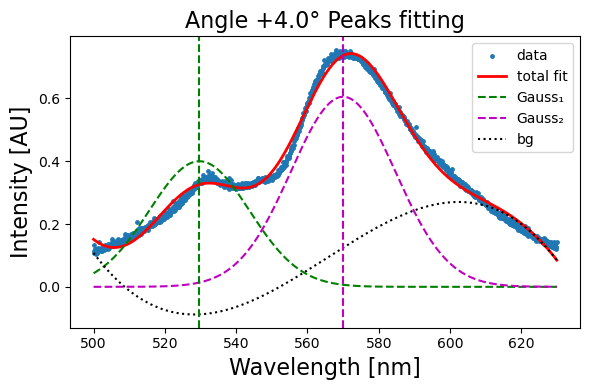


Angle +6.0°
  Gauss1: μ₁ = 529.59 ± 0.13, σ₁ = 13.85
  Gauss2: μ₂ = 569.62 ± 0.10, σ₂ = 14.67
  BG: p0–p3 = [-1.7299871975186963e-06, 0.0029339536919955954, -1.6515076890787292, 308.62686603666754]



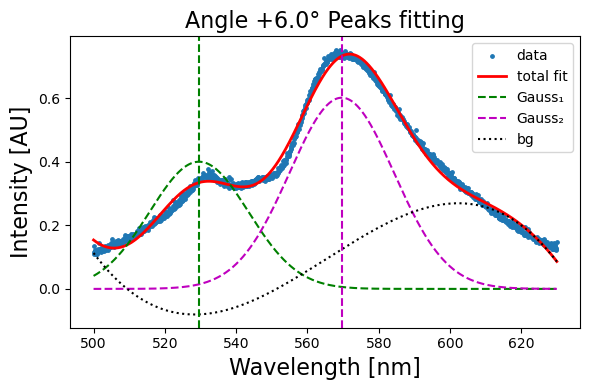


Angle +8.0°
  Gauss1: μ₁ = 529.45 ± 0.13, σ₁ = 13.69
  Gauss2: μ₂ = 569.24 ± 0.10, σ₂ = 14.66
  BG: p0–p3 = [-1.7026029566692053e-06, 0.0028867491180461775, -1.6245275170381346, 303.51929075266054]



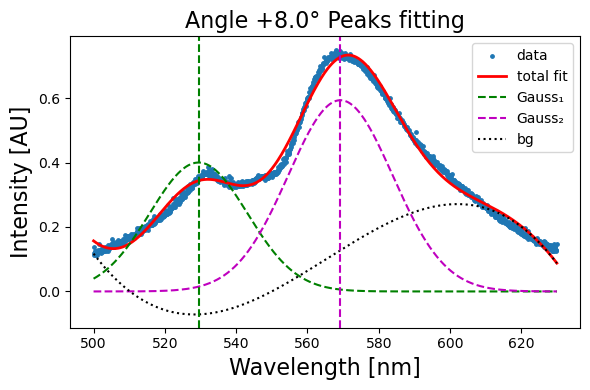

    angle         mu1   mu1_err     sigma1         mu2   mu2_err     sigma2
0   -10.0  529.872458  0.121841  12.983911  570.388070  0.076405  14.389502
1   -12.0  529.804236  0.121614  12.932963  570.158046  0.078361  14.392982
2   -14.0  529.800767  0.113908  11.870581  570.138155  0.068124  14.282504
3   -16.0  529.714320  0.110963  11.752542  569.846816  0.067646  14.171560
4   -18.0  529.513451  0.106873  11.605117  569.461463  0.068292  14.111523
5    -2.0  529.033411  0.122694  13.669027  570.496886  0.083491  15.232990
6   -20.0  529.393764  0.104570  11.570851  569.105358  0.069323  14.102904
7    -4.0  564.570072  0.352947  11.638753  598.255342  0.304767  19.259495
8    -6.0  529.487745  0.119022  12.843523  570.899072  0.072196  14.610287
9    -8.0  529.624062  0.122598  13.224052  570.599362  0.078633  14.342458
10    0.0  529.780907  0.131756  14.206895  570.408240  0.092845  14.566996
11   10.0  529.291993  0.130706  13.505841  568.737245  0.098729  14.683394
12   12.0  5

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# 1) Model: two Gaussians + cubic BG
def two_gauss_poly3_bg(x, A1, mu1, sigma1,
                          A2, mu2, sigma2,
                          p0, p1, p2, p3):
    g1 = A1*np.exp(-((x-mu1)**2)/(2*sigma1**2))
    g2 = A2*np.exp(-((x-mu2)**2)/(2*sigma2**2))
    bg = p0*x**3 + p1*x**2 + p2*x + p3
    return g1 + g2 + bg

fit_results = []

# 2) Loop over your angle/df pairs
for angle, df in data3:
    # trim to λ>500 and unpack
    df_cut = df[(df['wavel']>500)&(df['wavel']<630)].sort_values('wavel')
    x = df_cut['wavel'].values
    y = df_cut['I'].values

    # 3) pick the two largest peaks for initial μ’s
    peak_idxs = np.argsort(y)[-2:]
    mus = np.sort(x[peak_idxs])
    amps = y[peak_idxs]
    μ1, μ2 = 550, 580
    A1, A2 = 0.8, 0.6
    σ0 = 15

    # 4) initial guess
    p0 = [A1, μ1, σ0,
          A2, μ2, σ0,
          0, 0, 0, np.min(y)]

    # 5) sensible bounds
    lower = [0.4, x.min(), 8,
             0.4, x.min(), 8,
            -np.inf,-np.inf,-np.inf,-np.inf]
    upper = [1, x.max(), 40,
             0.8, x.max(), 20,
             np.inf, np.inf, np.inf, np.inf]

    # 6) fit
    popt, pcov = curve_fit(
        two_gauss_poly3_bg,
        x, y,
        p0=p0, bounds=(lower, upper),
        maxfev=20000
    )

    # 7) extract and print
    errs = np.sqrt(np.diag(pcov))
    A1f, μ1f, σ1f, A2f, μ2f, σ2f, *bgp = popt
    μ1e, μ2e = errs[1], errs[4]

    print(f"\nAngle {angle:+.1f}°")
    print(f"  Gauss1: μ₁ = {μ1f:.2f} ± {μ1e:.2f}, σ₁ = {σ1f:.2f}")
    print(f"  Gauss2: μ₂ = {μ2f:.2f} ± {μ2e:.2f}, σ₂ = {σ2f:.2f}")
    print(f"  BG: p0–p3 = {bgp}\n")

    fit_results.append((angle, popt, errs))

    # 8) plot data, fit, components
    xf = np.linspace(x.min(), x.max(), 800)
    total_fit = two_gauss_poly3_bg(xf, *popt)
    g1_fit = A1f*np.exp(-((xf-μ1f)**2)/(2*σ1f**2))
    g2_fit = A2f*np.exp(-((xf-μ2f)**2)/(2*σ2f**2))
    bg_fit = bgp[0]*xf**3 + bgp[1]*xf**2 + bgp[2]*xf + bgp[3]

    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=6, label="data")
    plt.plot(xf, total_fit, 'r-', lw=2, label="total fit")
    plt.plot(xf, g1_fit, 'g--', label="Gauss₁")
    plt.plot(xf, g2_fit, 'm--', label="Gauss₂")
    plt.plot(xf, bg_fit, 'k:', label="bg")
    plt.axvline(μ1f, color='g', ls='--')
    plt.axvline(μ2f, color='m', ls='--')
    plt.title(f"Angle {angle:+.1f}° Peaks fitting", fontsize=16)
    plt.xlabel("Wavelength [nm]", fontsize=16)
    plt.ylabel("Intensity [AU]", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 9) Summarize into a DataFrame
summary = pd.DataFrame([{
    'angle': angle,
    'mu1': p[1], 'mu1_err': e[1], 'sigma1': p[2],
    'mu2': p[4], 'mu2_err': e[4], 'sigma2': p[5]
} for angle, p, e in fit_results])

print(summary)



Angle -4.0°
  Gauss1: μ₁ = 529.29 ± 0.33, σ₁ = 15.35
  Gauss2: μ₂ = 560.07 ± 0.20, σ₂ = 9.21
  BG: p0–p3 = [-5.043756319979917e-06, 0.008575353842638706, -4.840045044641693, 907.0846316750851]



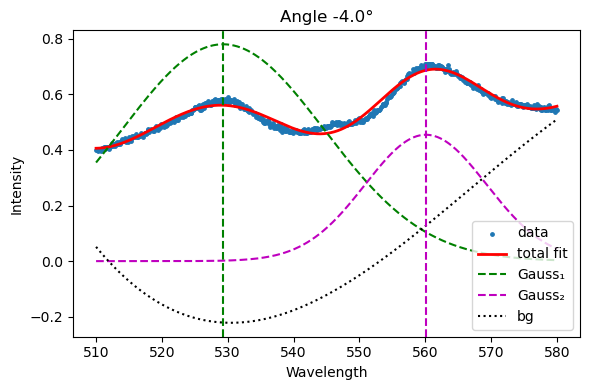

   angle         mu1   mu1_err     sigma1         mu2   mu2_err    sigma2
0   -4.0  529.292353  0.326097  15.350234  560.074483  0.195149  9.210768


In [56]:
#only -4

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# 1) Model: two Gaussians + cubic BG
def two_gauss_poly3_bg(x, A1, mu1, sigma1,
                          A2, mu2, sigma2,
                          p0, p1, p2, p3):
    g1 = A1*np.exp(-((x-mu1)**2)/(2*sigma1**2))
    g2 = A2*np.exp(-((x-mu2)**2)/(2*sigma2**2))
    bg = p0*x**3 + p1*x**2 + p2*x + p3
    return g1 + g2 + bg

fit_results = []

# 2) Loop over your angle/df pairs
for angle, df in data3[7:8]:
    # trim to λ>500 and unpack
    df_cut = df[(df['wavel']>510)&(df['wavel']<580)].sort_values('wavel')
    x = df_cut['wavel'].values
    y = df_cut['I'].values

    # 3) pick the two largest peaks for initial μ’s
    peak_idxs = np.argsort(y)[-2:]
    mus = np.sort(x[peak_idxs])
    amps = y[peak_idxs]
    μ1, μ2 = 530, 560
    A1, A2 = 0.6, 0.8
    σ0 = 15

    # 4) initial guess
    p0 = [A1, μ1, σ0,
          A2, μ2, σ0,
          0, 0, 0, np.min(y)]

    # 5) sensible bounds
    lower = [0.4, x.min(), 8,
             0.4, x.min(), 8,
            -np.inf,-np.inf,-np.inf,-np.inf]
    upper = [0.8, 540, 20,
            1, x.max(), 40,
             np.inf, np.inf, np.inf, np.inf]

    # 6) fit
    popt, pcov = curve_fit(
        two_gauss_poly3_bg,
        x, y,
        p0=p0, bounds=(lower, upper),
        maxfev=20000
    )

    # 7) extract and print
    errs = np.sqrt(np.diag(pcov))
    A1f, μ1f, σ1f, A2f, μ2f, σ2f, *bgp = popt
    μ1e, μ2e = errs[1], errs[4]

    print(f"\nAngle {angle:+.1f}°")
    print(f"  Gauss1: μ₁ = {μ1f:.2f} ± {μ1e:.2f}, σ₁ = {σ1f:.2f}")
    print(f"  Gauss2: μ₂ = {μ2f:.2f} ± {μ2e:.2f}, σ₂ = {σ2f:.2f}")
    print(f"  BG: p0–p3 = {bgp}\n")

    fit_results.append((angle, popt, errs))

    # 8) plot data, fit, components
    xf = np.linspace(x.min(), x.max(), 800)
    total_fit = two_gauss_poly3_bg(xf, *popt)
    g1_fit = A1f*np.exp(-((xf-μ1f)**2)/(2*σ1f**2))
    g2_fit = A2f*np.exp(-((xf-μ2f)**2)/(2*σ2f**2))
    bg_fit = bgp[0]*xf**3 + bgp[1]*xf**2 + bgp[2]*xf + bgp[3]

    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=6, label="data")
    plt.plot(xf, total_fit, 'r-', lw=2, label="total fit")
    plt.plot(xf, g1_fit, 'g--', label="Gauss₁")
    plt.plot(xf, g2_fit, 'm--', label="Gauss₂")
    plt.plot(xf, bg_fit, 'k:', label="bg")
    plt.axvline(μ1f, color='g', ls='--')
    plt.axvline(μ2f, color='m', ls='--')
    plt.title(f"Angle {angle:+.1f}°")
    plt.xlabel("Wavelength")
    plt.ylabel("Intensity")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 9) Summarize into a DataFrame
summary_4 = pd.DataFrame([{
    'angle': angle,
    'mu1': p[1], 'mu1_err': e[1], 'sigma1': p[2],
    'mu2': p[4], 'mu2_err': e[4], 'sigma2': p[5]
} for angle, p, e in fit_results])

print(summary_4)


In [59]:
summary

angle         mu1   mu1_err     sigma1         mu2   mu2_err     sigma2
0   -10.0  529.872458  0.121841  12.983911  570.388070  0.076405  14.389502
1   -12.0  529.804236  0.121614  12.932963  570.158046  0.078361  14.392982
2   -14.0  529.800767  0.113908  11.870581  570.138155  0.068124  14.282504
3   -16.0  529.714320  0.110963  11.752542  569.846816  0.067646  14.171560
4   -18.0  529.513451  0.106873  11.605117  569.461463  0.068292  14.111523
5    -2.0  529.033411  0.122694  13.669027  570.496886  0.083491  15.232990
6   -20.0  529.393764  0.104570  11.570851  569.105358  0.069323  14.102904
7    -4.0  564.570072  0.352947  11.638753  598.255342  0.304767  19.259495
8    -6.0  529.487745  0.119022  12.843523  570.899072  0.072196  14.610287
9    -8.0  529.624062  0.122598  13.224052  570.599362  0.078633  14.342458
10    0.0  529.780907  0.131756  14.206895  570.408240  0.092845  14.566996
11   10.0  529.291993  0.130706  13.505841  568.737245  0.098729  14.683394
12   12.0  529.152538  0.127643  13.281918  568.447044  0.097410  14.748648
13   14.0  528.898740  0.125756  13.118966  567.907718  0.099705  14.817282
14   16.0  528.587351  0.120896  12.881552  567.344327  0.100173  14.914896
15   18.0  528.225520  0.117365  12.653133  566.784547  0.100847  15.043177
16    2.0  529.733445  0.133424  14.179392  570.218776  0.095181  14.594648
17   20.0  527.775864  0.113942  12.523355  566.248629  0.102078  15.183466
18    4.0  529.681445  0.133367  14.064978  569.992988  0.095990  14.652732
19    6.0  529.590228  0.131998  13.847355  569.615809  0.095796  14.668646
20    8.0  529.453346  0.130770  13.690940  569.242728  0.096306  14.659708

In [60]:
summary.iloc[7] = summary_4
summary

angle         mu1   mu1_err     sigma1         mu2   mu2_err     sigma2
0   -10.0  529.872458  0.121841  12.983911  570.388070  0.076405  14.389502
1   -12.0  529.804236  0.121614  12.932963  570.158046  0.078361  14.392982
2   -14.0  529.800767  0.113908  11.870581  570.138155  0.068124  14.282504
3   -16.0  529.714320  0.110963  11.752542  569.846816  0.067646  14.171560
4   -18.0  529.513451  0.106873  11.605117  569.461463  0.068292  14.111523
5    -2.0  529.033411  0.122694  13.669027  570.496886  0.083491  15.232990
6   -20.0  529.393764  0.104570  11.570851  569.105358  0.069323  14.102904
7    -4.0  529.292353  0.326097  15.350234  560.074483  0.195149   9.210768
8    -6.0  529.487745  0.119022  12.843523  570.899072  0.072196  14.610287
9    -8.0  529.624062  0.122598  13.224052  570.599362  0.078633  14.342458
10    0.0  529.780907  0.131756  14.206895  570.408240  0.092845  14.566996
11   10.0  529.291993  0.130706  13.505841  568.737245  0.098729  14.683394
12   12.0  529.152538  0.127643  13.281918  568.447044  0.097410  14.748648
13   14.0  528.898740  0.125756  13.118966  567.907718  0.099705  14.817282
14   16.0  528.587351  0.120896  12.881552  567.344327  0.100173  14.914896
15   18.0  528.225520  0.117365  12.653133  566.784547  0.100847  15.043177
16    2.0  529.733445  0.133424  14.179392  570.218776  0.095181  14.594648
17   20.0  527.775864  0.113942  12.523355  566.248629  0.102078  15.183466
18    4.0  529.681445  0.133367  14.064978  569.992988  0.095990  14.652732
19    6.0  529.590228  0.131998  13.847355  569.615809  0.095796  14.668646
20    8.0  529.453346  0.130770  13.690940  569.242728  0.096306  14.659708

In [61]:
import math

n = 1.54
n_err = 0.154
hbar = 1.0546*10**(-34)
h = hbar*2*math.pi

c = 2.99792*10**8
L0 = 165*10**(-9)
L0_err = 15*10**(-9)

def calc_k(peak, theta):
    return 2*math.pi*(math.sin(math.radians(theta)))/peak    


def calc_Epol(peak):
    return h*c/peak

In [62]:
summary2 = copy.deepcopy(summary)
summary2['mu1'] = 10**(-9) * summary2['mu1']
summary2['mu2'] = 10**(-9) * summary2['mu2']
summary2['mu1_err'] = 10**(-9) * summary2['mu1_err']
summary2['mu2_err'] = 10**(-9) * summary2['mu2_err']

summary2


angle           mu1       mu1_err     sigma1           mu2       mu2_err  \
0   -10.0  5.298725e-07  1.218407e-10  12.983911  5.703881e-07  7.640472e-11   
1   -12.0  5.298042e-07  1.216143e-10  12.932963  5.701580e-07  7.836108e-11   
2   -14.0  5.298008e-07  1.139084e-10  11.870581  5.701382e-07  6.812352e-11   
3   -16.0  5.297143e-07  1.109630e-10  11.752542  5.698468e-07  6.764624e-11   
4   -18.0  5.295135e-07  1.068728e-10  11.605117  5.694615e-07  6.829185e-11   
5    -2.0  5.290334e-07  1.226943e-10  13.669027  5.704969e-07  8.349122e-11   
6   -20.0  5.293938e-07  1.045699e-10  11.570851  5.691054e-07  6.932281e-11   
7    -4.0  5.292924e-07  3.260971e-10  15.350234  5.600745e-07  1.951486e-10   
8    -6.0  5.294877e-07  1.190216e-10  12.843523  5.708991e-07  7.219627e-11   
9    -8.0  5.296241e-07  1.225983e-10  13.224052  5.705994e-07  7.863268e-11   
10    0.0  5.297809e-07  1.317560e-10  14.206895  5.704082e-07  9.284490e-11   
11   10.0  5.292920e-07  1.307060e-10  13.505841  5.687372e-07  9.872896e-11   
12   12.0  5.291525e-07  1.276432e-10  13.281918  5.684470e-07  9.740965e-11   
13   14.0  5.288987e-07  1.257556e-10  13.118966  5.679077e-07  9.970545e-11   
14   16.0  5.285874e-07  1.208960e-10  12.881552  5.673443e-07  1.001733e-10   
15   18.0  5.282255e-07  1.173652e-10  12.653133  5.667845e-07  1.008472e-10   
16    2.0  5.297334e-07  1.334243e-10  14.179392  5.702188e-07  9.518084e-11   
17   20.0  5.277759e-07  1.139416e-10  12.523355  5.662486e-07  1.020783e-10   
18    4.0  5.296814e-07  1.333666e-10  14.064978  5.699930e-07  9.598955e-11   
19    6.0  5.295902e-07  1.319984e-10  13.847355  5.696158e-07  9.579594e-11   
20    8.0  5.294533e-07  1.307703e-10  13.690940  5.692427e-07  9.630604e-11   

       sigma2  
0   14.389502  
1   14.392982  
2   14.282504  
3   14.171560  
4   14.111523  
5   15.232990  
6   14.102904  
7    9.210768  
8   14.610287  
9   14.342458  
10  14.566996  
11  14.683394  
12  14.748648  
13  14.817282  
14  14.914896  
15  15.043177  
16  14.594648  
17  15.183466  
18  14.652732  
19  14.668646  
20  14.659708

In [63]:
summary2['angle_err'] = 2/math.sqrt(12)

In [64]:
summary2['k_l'] = summary2.apply(lambda row: calc_k(row['mu1'], row['angle']), axis=1)
summary2['k_u'] = summary2.apply(lambda row: calc_k(row['mu2'], row['angle']), axis=1)
summary2['Epol_l'] = summary2.apply(lambda row: calc_Epol(row['mu1']), axis=1)
summary2['Epol_u'] = summary2.apply(lambda row: calc_Epol(row['mu2']), axis=1)


In [65]:
def calc_k_err(mu, theta, mu_err, theta_err):
    return 2*math.pi* math.sqrt((mu_err*math.sin(math.radians(theta))/mu**2)**2+(math.radians(theta_err)/mu*math.cos(math.radians(theta)))**2)

In [66]:
def calc_E_err(mu, mu_err):
    return h*c*mu_err/mu**2

In [67]:
summary2['kl_err'] = summary2.apply(lambda row: calc_k_err(row['mu1'], row['angle'], row['mu1_err'], row['angle_err']), axis=1)

In [69]:
summary2['ku_err'] = summary2.apply(lambda row: calc_k_err(row['mu2'], row['angle'], row['mu2_err'], row['angle_err']), axis=1)

In [70]:
summary2['El_err'] = summary2.apply(lambda row: calc_E_err(row['mu1'], row['mu1_err']), axis=1)

In [71]:
summary2['Eu_err'] = summary2.apply(lambda row: calc_E_err(row['mu2'], row['mu2_err']), axis=1)

In [72]:
summary2.sort_values(by='angle')

angle           mu1       mu1_err     sigma1           mu2       mu2_err  \
6   -20.0  5.293938e-07  1.045699e-10  11.570851  5.691054e-07  6.932281e-11   
4   -18.0  5.295135e-07  1.068728e-10  11.605117  5.694615e-07  6.829185e-11   
3   -16.0  5.297143e-07  1.109630e-10  11.752542  5.698468e-07  6.764624e-11   
2   -14.0  5.298008e-07  1.139084e-10  11.870581  5.701382e-07  6.812352e-11   
1   -12.0  5.298042e-07  1.216143e-10  12.932963  5.701580e-07  7.836108e-11   
0   -10.0  5.298725e-07  1.218407e-10  12.983911  5.703881e-07  7.640472e-11   
9    -8.0  5.296241e-07  1.225983e-10  13.224052  5.705994e-07  7.863268e-11   
8    -6.0  5.294877e-07  1.190216e-10  12.843523  5.708991e-07  7.219627e-11   
7    -4.0  5.292924e-07  3.260971e-10  15.350234  5.600745e-07  1.951486e-10   
5    -2.0  5.290334e-07  1.226943e-10  13.669027  5.704969e-07  8.349122e-11   
10    0.0  5.297809e-07  1.317560e-10  14.206895  5.704082e-07  9.284490e-11   
16    2.0  5.297334e-07  1.334243e-10  14.179392  5.702188e-07  9.518084e-11   
18    4.0  5.296814e-07  1.333666e-10  14.064978  5.699930e-07  9.598955e-11   
19    6.0  5.295902e-07  1.319984e-10  13.847355  5.696158e-07  9.579594e-11   
20    8.0  5.294533e-07  1.307703e-10  13.690940  5.692427e-07  9.630604e-11   
11   10.0  5.292920e-07  1.307060e-10  13.505841  5.687372e-07  9.872896e-11   
12   12.0  5.291525e-07  1.276432e-10  13.281918  5.684470e-07  9.740965e-11   
13   14.0  5.288987e-07  1.257556e-10  13.118966  5.679077e-07  9.970545e-11   
14   16.0  5.285874e-07  1.208960e-10  12.881552  5.673443e-07  1.001733e-10   
15   18.0  5.282255e-07  1.173652e-10  12.653133  5.667845e-07  1.008472e-10   
17   20.0  5.277759e-07  1.139416e-10  12.523355  5.662486e-07  1.020783e-10   

       sigma2  angle_err           k_l           k_u        Epol_l  \
6   14.102904    0.57735 -4.059315e+06 -3.776060e+06  3.752398e-19   
4   14.111523    0.57735 -3.666783e+06 -3.409557e+06  3.751549e-19   
3   14.171560    0.57735 -3.269462e+06 -3.039204e+06  3.750127e-19   
2   14.282504    0.57735 -2.869079e+06 -2.666091e+06  3.749515e-19   
1   14.392982    0.57735 -2.465718e+06 -2.291203e+06  3.749490e-19   
0   14.389502    0.57735 -2.059106e+06 -1.912844e+06  3.749008e-19   
9   14.342458    0.57735 -1.651078e+06 -1.532512e+06  3.750766e-19   
8   14.610287    0.57735 -1.240391e+06 -1.150416e+06  3.751732e-19   
7    9.210768    0.57735 -8.280733e+05 -7.825617e+05  3.753117e-19   
5   15.232990    0.57735 -4.144918e+05 -3.843667e+05  3.754954e-19   
10  14.566996    0.57735  0.000000e+00  0.000000e+00  3.749656e-19   
16  14.594648    0.57735  4.139440e+05  3.845542e+05  3.749991e-19   
18  14.652732    0.57735  8.274650e+05  7.689443e+05  3.750360e-19   
19  14.668646    0.57735  1.240151e+06  1.153008e+06  3.751006e-19   
20  14.659708    0.57735  1.651610e+06  1.536164e+06  3.751975e-19   
11  14.683394    0.57735  2.061364e+06  1.918397e+06  3.753119e-19   
12  14.748648    0.57735  2.468754e+06  2.298099e+06  3.754108e-19   
13  14.817282    0.57735  2.873972e+06  2.676562e+06  3.755910e-19   
14  14.914896    0.57735  3.276432e+06  3.052609e+06  3.758122e-19   
15  15.043177    0.57735  3.675724e+06  3.425660e+06  3.760697e-19   
17  15.183466    0.57735  4.071759e+06  3.795110e+06  3.763901e-19   

          Epol_u         kl_err         ku_err        El_err        Eu_err  
6   3.490559e-19  112386.632249  104542.758304  7.412021e-23  4.251855e-23  
4   3.488376e-19  113719.550393  105740.617424  7.571833e-23  4.183386e-23  
3   3.486017e-19  114895.825030  106802.789899  7.855655e-23  4.138234e-23  
2   3.484236e-19  115956.284035  107751.300200  8.061543e-23  4.163174e-23  
1   3.484114e-19  116893.582164  108619.442740  8.606794e-23  4.788479e-23  
0   3.482709e-19  117673.924265  109314.765505  8.620599e-23  4.665165e-23  
9   3.481420e-19  118381.527565  109880.064185  8.682335e-23  4.797646e-23  
8   3.479592e-19  118920.366399  110294.028167  8.433379e-23  4.400315e-23  
7   3.546

In [73]:
El_err = summary2['El_err'].values
Eu_err = summary2['Eu_err'].values
kl_err = summary2['kl_err'].values
ku_err = summary2['ku_err'].values


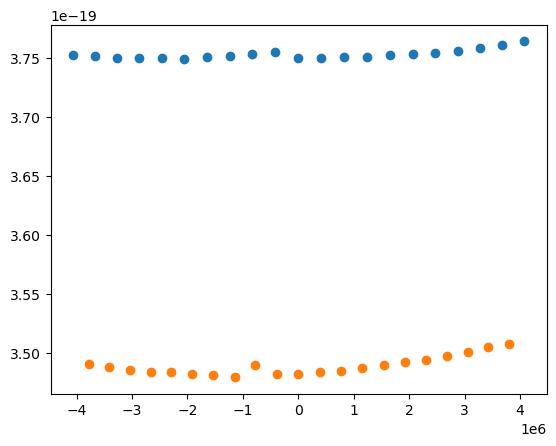

In [80]:

plt.scatter(summary2['k_l'], summary2['Epol_l'])
plt.scatter(summary2['k_u'], summary2['Epol_u'])


Fit results:
 A       = 2.750e-19 ± 5.7e-17 J
 ħΩ      = 2.750e-20 ± 2.0e-16 J
 b1      = 2.059e-26 ± 7.7e-23
 n       = 1.5355 ± 5725.8315


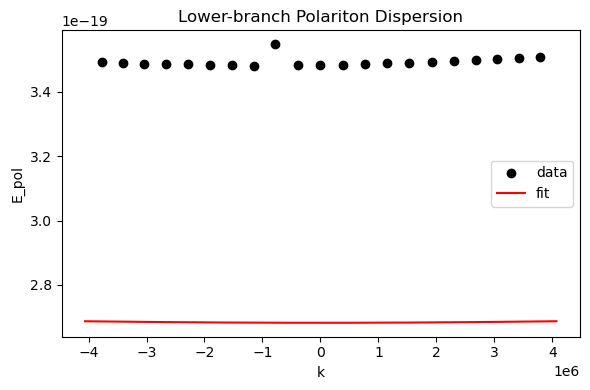

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ——————————————————————————
# 1) Plug in your actual data here
# k_l = summary2['k_l'].values
# E_l = summary2['Epol_l'].values
#———————————————————————————

# Example placeholders (erase these two lines):
k_u = summary2['k_u'].values
E_u = summary2['Epol_u'].values

# Physical constants
hbar = 1.0545718e-34
c    = 2.99792e8
L0   = 165e-9
b2   = np.pi / L0

# Dispersion function with b1 = ℏ c / n as a free parameter
def E_upper_param(k, A, hOmega, b1):
    term   = b1 * np.sqrt(k**2 + b2**2)
    inside = np.sqrt((A - term)**2 + 4*hOmega**2)
    return 0.5 * (A + term - inside)

# Initial guesses — choose something physicist-sensible:
b10 = hbar * c / 1.65               # corresponds to n≈1.6
p0 = [3e-19,   2.5e-20,  b10]    # [A0, ℏΩ0, b10]

# Bounds — wide enough to let the fit roam:
bounds = (
    [0.5e-19, 0.5e-20, hbar*c/1.7],    # lower limit on [A, ℏΩ, b1]
    [5.0e-19, 5.0e-20, hbar*c/1.4]     # upper limit on [A, ℏΩ, b1]
)

# Perform the fit
popt, pcov = curve_fit(
    E_upper_param, k_l, E_l,
    p0=p0, bounds=bounds, maxfev=1000000
)
A_fit, hOmega_fit, b1_fit = popt
A_err, hOmega_err, b1_err = np.sqrt(np.diag(pcov))

# Recover n (and its error via simple propagation)
n_fit   = (hbar * c) / b1_fit
n_err   = (b1_err / b1_fit) * n_fit

print("Fit results:")
print(f" A       = {A_fit:.3e} ± {A_err:.1e} J")
print(f" ħΩ      = {hOmega_fit:.3e} ± {hOmega_err:.1e} J")
print(f" b1      = {b1_fit:.3e} ± {b1_err:.1e}")
print(f" n       = {n_fit:.4f} ± {n_err:.4f}")

# Visualization
k_plot = np.linspace(k_l.min(), k_l.max(), 300)
E_plot = E_upper_param(k_plot, *popt)

plt.figure(figsize=(6,4))
plt.scatter(k_u, E_u, label="data", color='k')
plt.plot(k_plot, E_plot, 'r-', label="fit")
plt.xlabel("k")
plt.ylabel("E_pol")
plt.title("Lower-branch Polariton Dispersion")
plt.legend()
plt.tight_layout()
plt.show()


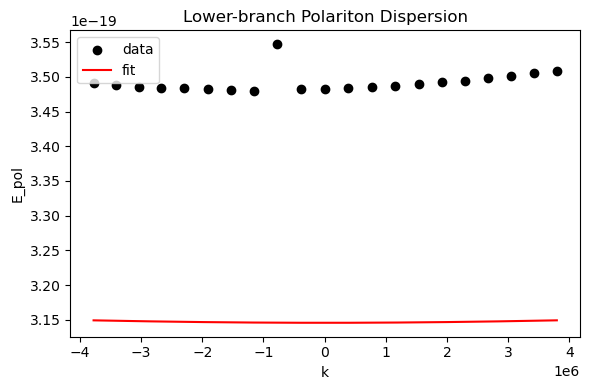

In [175]:
hbar = 1.0545718e-34
c    = 2.99792e8
L0   = 165e-9
n = 1.4
Au = 3.2e-19
Al = 2.8e-19

hOmegau = 2.5e-20
hOmegal = 3e-20

b2   = np.pi / L0
b1 = hbar*c/n

# Dispersion function with b1 = ℏ c / n as a free parameter
def E_upper_param2(k):
    term   = b1 * np.sqrt(k**2 + b2**2)
    inside = np.sqrt((Au - term)**2 + 4*hOmegau**2)
    return 0.5 * (Au + term - inside)

def E_lower_param2(k):
    term   = b1 * np.sqrt(k**2 + b2**2)
    inside = np.sqrt((Al - term)**2 + 4*hOmegal**2)
    return 0.5 * (Al + term + inside)


ku_plot = np.linspace(k_u.min(), k_u.max(), 300)
Eu_plot = E_upper_param2(ku_plot)
#kl_plot = np.linspace(k_l.min(), k_l.max(), 300)
#El_plot = E_lower_param2(kl_plot)
plt.figure(figsize=(6,4))
plt.scatter(k_u, E_u, label="data", color='k')
plt.plot(ku_plot, Eu_plot, 'r-', label="fit")
#plt.scatter(k_l, E_l, label="data", color='k')
#plt.plot(kl_plot, El_plot, 'r-', label="fit")

plt.xlabel("k")
plt.ylabel("E_pol")
plt.title("Lower-branch Polariton Dispersion")
plt.legend()
plt.tight_layout()
plt.show()


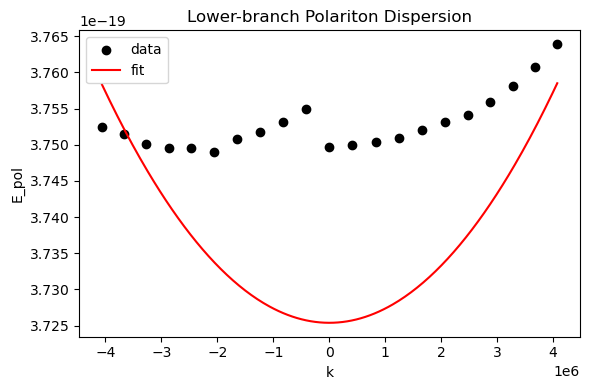

In [279]:
hbar = 1.0545718e-34
c    = 2.99792e8
L0   = 162e-9
n = 2.05
Al = 3.0e-19

hOmegal = 7.3e-20

b2   = np.pi / L0
b1 = hbar*c/n

# Dispersion function with b1 = ℏ c / n as a free parameter
def E_upper_param2(k):
    term   = b1 * np.sqrt(k**2 + b2**2)
    inside = np.sqrt((Au - term)**2 + 4*hOmegau**2)
    return 0.5 * (Au + term - inside)

def E_lower_param2(k):
    term   = b1 * np.sqrt(k**2 + b2**2)
    inside = np.sqrt((Al - term)**2 + 4*hOmegal**2)
    return 0.5 * (Al + term + inside)



kl_plot = np.linspace(k_l.min(), k_l.max(), 300)
El_plot = E_lower_param2(kl_plot)
plt.figure(figsize=(6,4))

plt.scatter(k_l, E_l, label="data", color='k')
plt.plot(kl_plot, El_plot, 'r-', label="fit")

plt.xlabel("k")
plt.ylabel("E_pol")
plt.title("Lower-branch Polariton Dispersion")
plt.legend()
plt.tight_layout()
plt.show()


Fitted parameters:
  Al      = 4.600e-19
  n       = 1.540
  L0      = 1.650e-07 m
  hOmegal = 7.200e-20 J


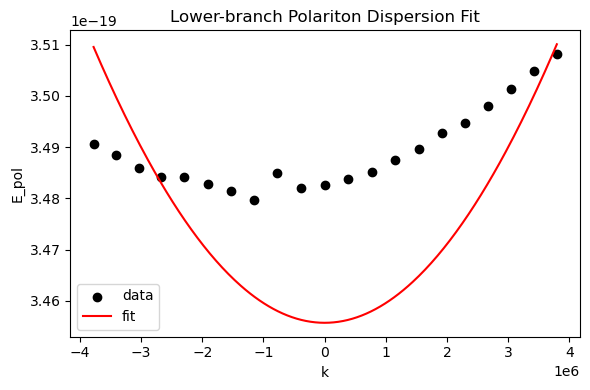

In [317]:
# Fitting lower-branch dispersion with four free parameters

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants for initial guess
hbar    = 1.0545718e-34
c       = 2.99792e8
L0      = 165e-9
n       = 1.54
hOmegal = 7.2e-20
Al      = 4.6e-19

# Define the model function with four parameters
def E_upper(k, Al, n, L0, hOmegal):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1 * np.sqrt(k**2 + b2**2))**2 + 4 * hOmegal**2)
    return 0.5 * (Al + b1 * np.sqrt(k**2 + b2**2) - inside)

# Experimental data arrays: k_l, E_l
# (Ensure k_l and E_l are defined in your notebook)

# Initial parameter guesses
p0 = [Al, n, L0, hOmegal]
lb = [val*0.5 for val in p0]
ub = [val*1.5 for val in p0]

popt, pcov = curve_fit(
    E_upper, k_u, E_u,
    p0=p0,
    bounds=(lb, ub),
    method='trf',          # trust‐region reflective
    ftol=1e-15,            # cost‐function tolerance
    xtol=1e-20,            # parameter tolerance
    gtol=1e-20,            # gradient tolerance
    max_nfev=20000000        # allow more function evaluations
)
# Extract fitted parameters
Al_fit, n_fit, L0_fit, hOmegal_fit = popt
print("Fitted parameters:")
print(f"  Al      = {Al_fit:.3e}")
print(f"  n       = {n_fit:.3f}")
print(f"  L0      = {L0_fit:.3e} m")
print(f"  hOmegal = {hOmegal_fit:.3e} J")

# Plot data and fitted curve
ku_plot = np.linspace(k_u.min(), k_u.max(), 300)
Eu_fit   = E_upper(ku_plot, *popt)

plt.figure(figsize=(6,4))
plt.scatter(k_u, E_u, color='k', label='data')
plt.plot(ku_plot, Eu_fit, 'r-', label='fit')
plt.xlabel("k")
plt.ylabel("E_pol")
plt.title("Lower-branch Polariton Dispersion Fit")
plt.legend()
plt.tight_layout()
plt.show()


In [316]:
E_u[7] = 3.485e-19

Best‐grid parameters:
  Al      = 3.980e-19
  n       = 2.032
  L0      = 1.166e-07 m
  hOmegal = 5.939e-20 J
  Cost    = 6.744e-42


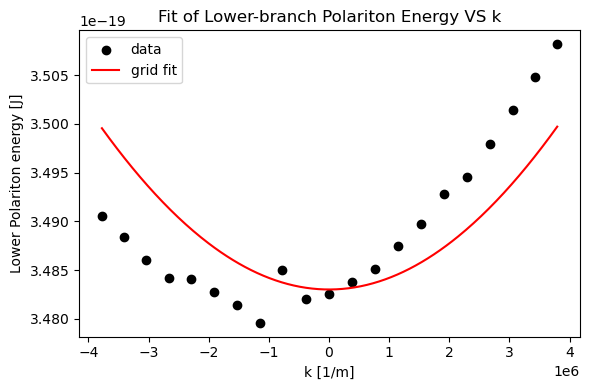

In [320]:
# Grid‐Search Fit of Upper‐Branch Dispersion with Four Parameters

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Ensure your data arrays k_u, E_u are defined in the notebook

# Model definition (reuse your E_upper)
hbar    = 1.0545718e-34
c       = 2.99792e8

def E_upper(k, Al, n, L0, hOmegal):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1 * np.sqrt(k**2 + b2**2))**2 + 4 * hOmegal**2)
    return 0.5 * (Al + b1 * np.sqrt(k**2 + b2**2) - inside)

# Initial guesses and search bounds (±50%)
Al0, n0, L00, hO0 = 3.8e-19, 2, 105e-9, 5.2e-20
factor = 0.3
N=20
Al_vals   = np.linspace(Al0*(1-factor),  Al0*(1+factor),  N)
n_vals    = np.linspace(n0*(1-factor),   n0*(1+factor),   N)
L0_vals   = np.linspace(L00*(1-factor), L00*(1+factor), N)
hO_vals   = np.linspace(hO0*(1-factor), hO0*(1+factor), N)

best_cost = np.inf
best_params = None

# 4D grid search
for Al_x in Al_vals:
    for n_x in n_vals:
        for L0_x in L0_vals:
            for hO_x in hO_vals:
                E_pred = E_upper(k_u, Al_x, n_x, L0_x, hO_x)
                cost = np.sum((E_pred - E_u)**2)
                if cost < best_cost:
                    best_cost = cost
                    best_params = (Al_x, n_x, L0_x, hO_x)

Al_fit, n_fit, L0_fit, hO_fit = best_params
print("Best‐grid parameters:")
print(f"  Al      = {Al_fit:.3e}")
print(f"  n       = {n_fit:.3f}")
print(f"  L0      = {L0_fit:.3e} m")
print(f"  hOmegal = {hO_fit:.3e} J")
print(f"  Cost    = {best_cost:.3e}")

# Plot data vs. best‐fit
k_plot = np.linspace(k_u.min(), k_u.max(), 300)
E_best = E_upper(k_plot, *best_params)

plt.figure(figsize=(6,4))
plt.scatter(k_u, E_u, color='k', label='data')
plt.plot(k_plot, E_best, 'r-', label='fit')
plt.xlabel('k [1/m]')
plt.ylabel('Lower Polariton energy [J]')
plt.title('Fit of Lower-branch Polariton Energy VS k')
plt.legend()
plt.tight_layout()
plt.show()


Fitted parameters:
  Al      = 4.600e-19
  n       = 1.540
  L0      = 1.650e-07 m
  hOmegal = 7.200e-20 J


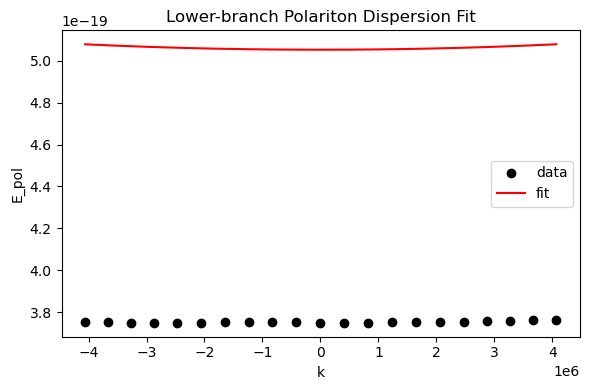

In [302]:
# Jupyter cell: fit lower‐branch dispersion with four free parameters

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants & initial guesses
hbar    = 1.0545718e-34
c       = 2.99792e8
L0      = 165e-9
n       = 1.54
hOmegal = 7.2e-20
Al      = 4.6e-19

# Lower-branch model
def E_lower(k, Al, n, L0, hOmegal):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1 * np.sqrt(k**2 + b2**2))**2 + 4 * hOmegal**2)
    return 0.5 * (Al + b1 * np.sqrt(k**2 + b2**2) + inside)

# Data arrays: k_l, E_l (must be defined)
# Setup initial parameters and bounds (±50%)
p0 = [Al, n, L0, hOmegal]
lb = [val * 0.5 for val in p0]
ub = [val * 1.5 for val in p0]

# Perform fit with tight tolerances
popt, pcov = curve_fit(
    E_lower, k_l, E_l,
    p0=p0, bounds=(lb, ub), method='trf',
    ftol=1e-15, xtol=1e-20, gtol=1e-20, max_nfev=2_0000_0000
)

# Extract fitted parameters
Al_fit, n_fit, L0_fit, hOmegal_fit = popt
print("Fitted parameters:")
print(f"  Al      = {Al_fit:.3e}")
print(f"  n       = {n_fit:.3f}")
print(f"  L0      = {L0_fit:.3e} m")
print(f"  hOmegal = {hOmegal_fit:.3e} J")

# Plot data and fit
k_plot = np.linspace(k_l.min(), k_l.max(), 300)
E_fit  = E_lower(k_plot, *popt)

plt.figure(figsize=(6,4))
plt.scatter(k_l, E_l, color='k', label='data')
plt.plot(k_plot, E_fit, 'r-', label='fit')
plt.xlabel("k")
plt.ylabel("E_pol")
plt.title("Lower-branch Polariton Dispersion Fit")
plt.legend()
plt.tight_layout()
plt.show()


Best-fit parameters from grid search:
  Al      = 3.537e-19
  n       = 2.653
  L0      = 1.724e-07 m
  hOmegal = 5.811e-20 J
  Cost    = 2.164e-42


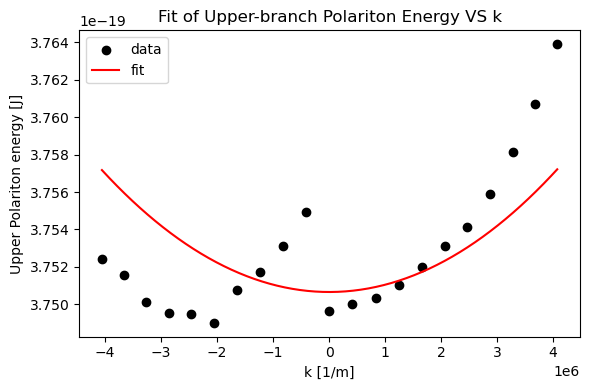

In [321]:
# Grid Search over 4D Parameter Space for Best Fit

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Ensure k_l and E_l are defined in your notebook from your data

# Model function (reuse from your cell)
hbar    = 1.0545718e-34
c       = 2.99792e8

def E_lower(k, Al, n, L0, hOmegal):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1 * np.sqrt(k**2 + b2**2))**2 + 4 * hOmegal**2)
    return 0.5 * (Al + b1 * np.sqrt(k**2 + b2**2) + inside)

# Initial guesses and bounds
Al0, n0, L00, hO0 = 3.5e-19, 2.8, 182e-9, 6.9e-20
factor = 0.2   # +/-50%
# Define grid resolution per parameter
N = 20

Al_vals     = np.linspace(Al0*(1-factor), Al0*(1+factor), N)
n_vals      = np.linspace(n0*(1-factor),  n0*(1+factor),  N)
L0_vals     = np.linspace(L00*(1-factor), L00*(1+factor), N)
hO_vals     = np.linspace(hO0*(1-factor), hO0*(1+factor), N)

best_cost = np.inf
best_params = None

# 4D grid search (N^4 loops)
for Al_x in Al_vals:
    for n_x in n_vals:
        for L0_x in L0_vals:
            for hO_x in hO_vals:
                E_pred = E_lower(k_l, Al_x, n_x, L0_x, hO_x)
                cost = np.sum((E_pred - E_l)**2)
                if cost < best_cost:
                    best_cost = cost
                    best_params = (Al_x, n_x, L0_x, hO_x)

Al_fit, n_fit, L0_fit, hO_fit = best_params
print("Best-fit parameters from grid search:")
print(f"  Al      = {Al_fit:.3e}")
print(f"  n       = {n_fit:.3f}")
print(f"  L0      = {L0_fit:.3e} m")
print(f"  hOmegal = {hO_fit:.3e} J")
print(f"  Cost    = {best_cost:.3e}")

# Plot the best-fit curve over data
kl_plot = np.linspace(k_l.min(), k_l.max(), 300)
El_best = E_lower(kl_plot, *best_params)

plt.figure(figsize=(6,4))
plt.scatter(k_l, E_l, color='k', label='data')
plt.plot(kl_plot, El_best, 'r-', label='fit')
plt.xlabel("k [1/m]")
plt.ylabel("Upper Polariton energy [J]")
plt.title("Fit of Upper-branch Polariton Energy VS k")
plt.legend()
plt.tight_layout()
plt.show()


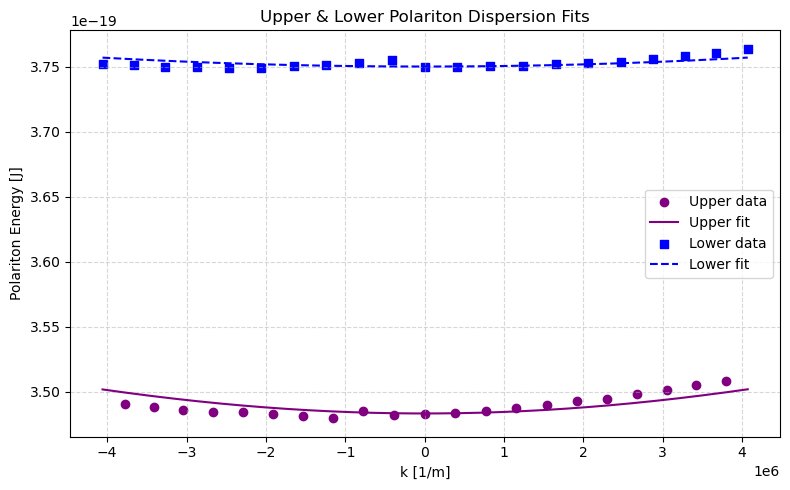

In [325]:
# Combined Grid‐Search and Plot for Upper & Lower Polariton Branches

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Ensure your data arrays k_u, E_u, k_l, E_l are defined in the notebook

# Physical constants
hbar = 1.0545718e-34
c    = 2.99792e8

# Model functions
def E_upper(k, Al, n, L0, hO):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1*np.sqrt(k**2 + b2**2))**2 + 4*hO**2)
    return 0.5*(Al + b1*np.sqrt(k**2 + b2**2) - inside)

def E_lower(k, Al, n, L0, hO):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1*np.sqrt(k**2 + b2**2))**2 + 4*hO**2)
    return 0.5*(Al + b1*np.sqrt(k**2 + b2**2) + inside)

# Initial guesses and ± range factors
# Upper branch initial
Al_u0, n_u0, L0_u0, hO_u0 = 3.8e-19, 2.0, 105e-9, 5.2e-20
# Lower branch initial
Al_l0, n_l0, L0_l0, hO_l0 = 3.5e-19, 2.8, 182e-9, 6.9e-20

factor_u, factor_l = 0.3, 0.2
N = 15  # grid resolution

# Build parameter grids
Al_u_vals = np.linspace(Al_u0*(1-factor_u), Al_u0*(1+factor_u), N)
n_u_vals  = np.linspace(n_u0*(1-factor_u),  n_u0*(1+factor_u),  N)
L0_u_vals = np.linspace(L0_u0*(1-factor_u), L0_u0*(1+factor_u), N)
hO_u_vals = np.linspace(hO_u0*(1-factor_u), hO_u0*(1+factor_u), N)

Al_l_vals = np.linspace(Al_l0*(1-factor_l), Al_l0*(1+factor_l), N)
n_l_vals  = np.linspace(n_l0*(1-factor_l),  n_l0*(1+factor_l),  N)
L0_l_vals = np.linspace(L0_l0*(1-factor_l), L0_l0*(1+factor_l), N)
hO_l_vals = np.linspace(hO_l0*(1-factor_l), hO_l0*(1+factor_l), N)

# Grid search for upper branch
best_cost_u = np.inf
best_params_u = None
for Al_x in Al_u_vals:
    for n_x in n_u_vals:
        for L0_x in L0_u_vals:
            for hO_x in hO_u_vals:
                pred = E_upper(k_u, Al_x, n_x, L0_x, hO_x)
                cost = np.sum((pred - E_u)**2)
                if cost < best_cost_u:
                    best_cost_u = cost
                    best_params_u = (Al_x, n_x, L0_x, hO_x)

# Grid search for lower branch
best_cost_l = np.inf
best_params_l = None
for Al_x in Al_l_vals:
    for n_x in n_l_vals:
        for L0_x in L0_l_vals:
            for hO_x in hO_l_vals:
                pred = E_lower(k_l, Al_x, n_x, L0_x, hO_x)
                cost = np.sum((pred - E_l)**2)
                if cost < best_cost_l:
                    best_cost_l = cost
                    best_params_l = (Al_x, n_x, L0_x, hO_x)

# Generate a common k‐axis
k_min = min(k_u.min(), k_l.min())
k_max = max(k_u.max(), k_l.max())
k_plot = np.linspace(k_min, k_max, 300)

# Compute fitted curves
E_u_fit = E_upper(k_plot, *best_params_u)
E_l_fit = E_lower(k_plot, *best_params_l)

# Combined plot
plt.figure(figsize=(8,5))
plt.scatter(k_u, E_u, color='purple', marker='o', label='Upper data')
plt.plot(k_plot, E_u_fit, color='purple', linestyle='-', label='Upper fit')
plt.scatter(k_l, E_l, color='blue', marker='s', label='Lower data')
plt.plot(k_plot, E_l_fit, color='blue', linestyle='--', label='Lower fit')

plt.xlabel('k [1/m]')
plt.ylabel('Polariton Energy [J]')
plt.title('Upper & Lower Polariton Dispersion Fits')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


Best‐grid parameters:
 Upper branch:
 Upper branch:
  E_exc  = 2.490e+00 ± 1.765e-01 eV
  E_exc      = 3.990e-19 ± 2.827e-20 [J]
  n       = 2.150 ± 0.000
  L0      = 1.102e-07 ± 1.393e-31 [m]
  Omega = 5.671e+14 ± 9.892e+13 [1/s]
  R² = 0.4421
  Reduced χ² = 161.3797
 Lower branch:
  E_exc      = 2.221e+00 ± 5.503e-02 [eV]
  n       = 2.520 ± 0.000
  L0      = 1.941e-07 ± 2.121e-33 [m]
  Omega = 5.452e+14 ± 1.201e+14 [1/s]
  R² = 0.2981
  Reduced χ² = 18.7996


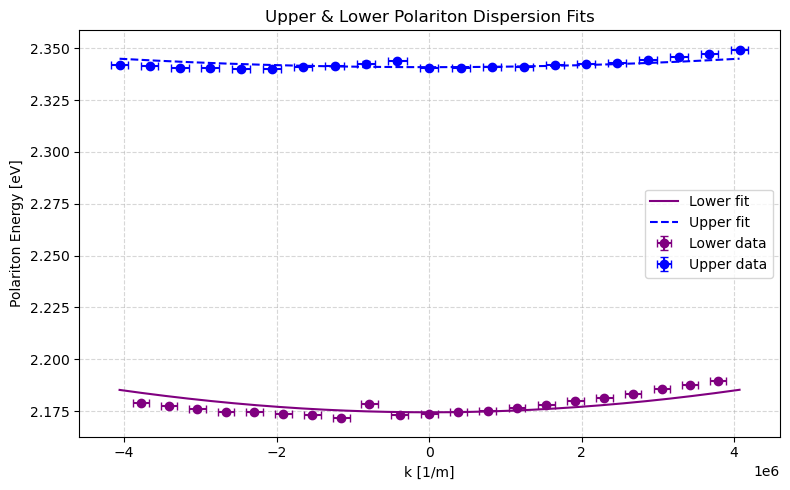

C:\Users\Shany\AppData\Local\Temp\ipykernel_23700\2305770508.py:341: RuntimeWarning: invalid value encountered in divide
  corr_u = pcov_u / np.outer(np.sqrt(np.diag(pcov_u)), np.sqrt(np.diag(pcov_u)))
C:\Users\Shany\AppData\Local\Temp\ipykernel_23700\2305770508.py:357: RuntimeWarning: invalid value encountered in divide
  corr_l = pcov_l / np.outer(np.sqrt(np.diag(pcov_l)), np.sqrt(np.diag(pcov_l)))


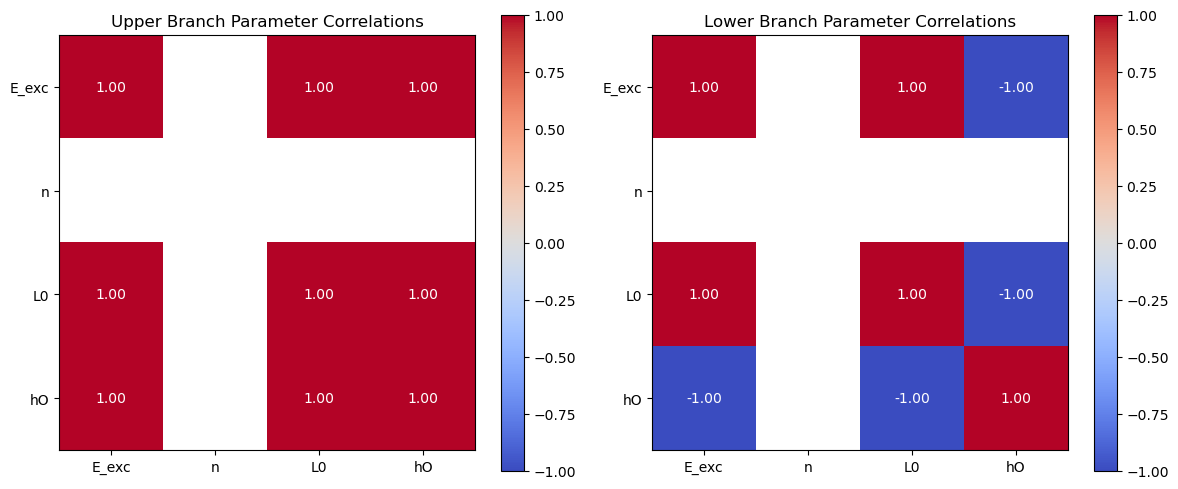

In [99]:
# Combined Grid‐Search, Parameter Printing, and Plot for Upper & Lower Polariton Branches
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Ensure your data arrays k_u, E_u, k_l, E_l are defined in the notebook
# Physical constants
hbar = 1.0545718e-34
c    = 2.99792e8
qe = 1.602176634e-19   # J per eV


# Model functions
def E_upper(k, Al, n, L0, hO):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1*np.sqrt(k**2 + b2**2))**2 + 4*hO**2)
    return 0.5*(Al + b1*np.sqrt(k**2 + b2**2) - inside)

def E_lower(k, Al, n, L0, hO):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1*np.sqrt(k**2 + b2**2))**2 + 4*hO**2)
    return 0.5*(Al + b1*np.sqrt(k**2 + b2**2) + inside)

# Initial guesses and ± range factors
# Upper branch initial
Al_u0, n_u0, L0_u0, hO_u0 = 3.8e-19, 2.0, 105e-9, 5.2e-20
# Lower branch initial
Al_l0, n_l0, L0_l0, hO_l0 = 3.5e-19, 2.8, 182e-9, 6.9e-20
factor_u, factor_l = 0.3, 0.2
N = 25  # grid resolution

# Build parameter grids for upper
Al_u_vals = np.linspace(Al_u0*(1-factor_u), Al_u0*(1+factor_u), N)
n_u_vals  = np.linspace(n_u0*(1-factor_u),  n_u0*(1+factor_u),  N)
L0_u_vals = np.linspace(L0_u0*(1-factor_u), L0_u0*(1+factor_u), N)
hO_u_vals = np.linspace(hO_u0*(1-factor_u), hO_u0*(1+factor_u), N)

# Build parameter grids for lower
Al_l_vals = np.linspace(Al_l0*(1-factor_l), Al_l0*(1+factor_l), N)
n_l_vals  = np.linspace(n_l0*(1-factor_l),  n_l0*(1+factor_l),  N)
L0_l_vals = np.linspace(L0_l0*(1-factor_l), L0_l0*(1+factor_l), N)
hO_l_vals = np.linspace(hO_l0*(1-factor_l), hO_l0*(1+factor_l), N)

# Grid search for upper branch
best_cost_u = np.inf
best_params_u = None
for Al_x in Al_u_vals:
    for n_x in n_u_vals:
        for L0_x in L0_u_vals:
            for hO_x in hO_u_vals:
                pred = E_upper(k_u, Al_x, n_x, L0_x, hO_x)
                cost = np.sum((pred - E_u)**2)
                if cost < best_cost_u:
                    best_cost_u = cost
                    best_params_u = (Al_x, n_x, L0_x, hO_x)

# Grid search for lower branch
best_cost_l = np.inf
best_params_l = None
for Al_x in Al_l_vals:
    for n_x in n_l_vals:
        for L0_x in L0_l_vals:
            for hO_x in hO_l_vals:
                pred = E_lower(k_l, Al_x, n_x, L0_x, hO_x)
                cost = np.sum((pred - E_l)**2)
                if cost < best_cost_l:
                    best_cost_l = cost
                    best_params_l = (Al_x, n_x, L0_x, hO_x)

# ---- ERROR ESTIMATION SECTION START ----

# Define wrapper functions for curve_fit compatibility
def E_upper_wrapper(k, Al, n, L0, hO):
    return E_upper(k, Al, n, L0, hO)

def E_lower_wrapper(k, Al, n, L0, hO):
    return E_lower(k, Al, n, L0, hO)

# Compute errors for upper branch using curve_fit
try:
    # Use the grid search best parameters as starting point for curve_fit
    bounds_u = (
        [best_params_u[0]*(1-factor_u), best_params_u[1]*(1-factor_u), 
         best_params_u[2]*(1-factor_u), best_params_u[3]*(1-factor_u)],
        [best_params_u[0]*(1+factor_u), best_params_u[1]*(1+factor_u), 
         best_params_u[2]*(1+factor_u), best_params_u[3]*(1+factor_u)]
    )
    
    popt_u, pcov_u = curve_fit(
        E_upper_wrapper, k_u, E_u, 
        p0=best_params_u,
        bounds=bounds_u,
        maxfev=10000
    )
    
    # Extract errors (standard deviations) from the covariance matrix diagonal
    err_u = np.sqrt(np.diag(pcov_u))
    
    # Check if any errors are NaN and handle
    if np.any(np.isnan(err_u)):
        print("Warning: Some upper branch parameter errors couldn't be determined.")
        # Set NaN errors to a percentage of the parameter value
        err_u = np.where(np.isnan(err_u), np.abs(popt_u) * 0.1, err_u)
    
    # Use the refined curve_fit parameters
    best_params_u = popt_u
    
except Exception as e:
    print(f"Error estimating upper branch uncertainties: {e}")
    # Fallback error estimation as percentage of parameter value
    err_u = [abs(p) * 0.1 for p in best_params_u]  # 10% error estimate
    print("Using approximate error estimates (10% of parameter values)")

# Compute errors for lower branch using curve_fit
try:
    # Use the grid search best parameters as starting point for curve_fit
    bounds_l = (
        [best_params_l[0]*(1-factor_l), best_params_l[1]*(1-factor_l), 
         best_params_l[2]*(1-factor_l), best_params_l[3]*(1-factor_l)],
        [best_params_l[0]*(1+factor_l), best_params_l[1]*(1+factor_l), 
         best_params_l[2]*(1+factor_l), best_params_l[3]*(1+factor_l)]
    )
    
    popt_l, pcov_l = curve_fit(
        E_lower_wrapper, k_l, E_l, 
        p0=best_params_l,
        bounds=bounds_l,
        maxfev=10000
    )
    
    # Extract errors (standard deviations) from the covariance matrix diagonal
    err_l = np.sqrt(np.diag(pcov_l))
    
    # Check if any errors are NaN and handle
    if np.any(np.isnan(err_l)):
        print("Warning: Some lower branch parameter errors couldn't be determined.")
        # Set NaN errors to a percentage of the parameter value
        err_l = np.where(np.isnan(err_l), np.abs(popt_l) * 0.1, err_l)
    
    # Use the refined curve_fit parameters
    best_params_l = popt_l
    
except Exception as e:
    print(f"Error estimating lower branch uncertainties: {e}")
    # Fallback error estimation as percentage of parameter value
    err_l = [abs(p) * 0.1 for p in best_params_l]  # 10% error estimate
    print("Using approximate error estimates (10% of parameter values)")

# Alternative error estimation method (parameter profiling)
# Only run if curve_fit method failed
if 'err_u' not in locals() or 'err_l' not in locals():
    print("Using profile likelihood method for error estimation...")
    
    # Function to estimate parameter errors by profiling
    def estimate_errors_by_profiling(k_data, E_data, best_params, model_func, param_ranges, num_points=10):
        Al_best, n_best, L0_best, hO_best = best_params
        Al_range, n_range, L0_range, hO_range = param_ranges
        
        # Best cost
        best_cost = np.sum((model_func(k_data, *best_params) - E_data)**2)
        threshold = best_cost * (1 + 1/len(k_data))  # Approximate for 1σ
        
        errors = []
        
        # Profile for Al
        costs = []
        Al_values = np.linspace(Al_range[0], Al_range[1], num_points)
        for Al in Al_values:
            cost = np.sum((model_func(k_data, Al, n_best, L0_best, hO_best) - E_data)**2)
            costs.append(cost)
        errors.append(estimate_error_from_profile(Al_values, costs, best_cost, threshold))
        
        # Profile for n
        costs = []
        n_values = np.linspace(n_range[0], n_range[1], num_points)
        for n in n_values:
            cost = np.sum((model_func(k_data, Al_best, n, L0_best, hO_best) - E_data)**2)
            costs.append(cost)
        errors.append(estimate_error_from_profile(n_values, costs, best_cost, threshold))
        
        # Profile for L0
        costs = []
        L0_values = np.linspace(L0_range[0], L0_range[1], num_points)
        for L0 in L0_values:
            cost = np.sum((model_func(k_data, Al_best, n_best, L0, hO_best) - E_data)**2)
            costs.append(cost)
        errors.append(estimate_error_from_profile(L0_values, costs, best_cost, threshold))
        
        # Profile for hO
        costs = []
        hO_values = np.linspace(hO_range[0], hO_range[1], num_points)
        for hO in hO_values:
            cost = np.sum((model_func(k_data, Al_best, n_best, L0_best, hO) - E_data)**2)
            costs.append(cost)
        errors.append(estimate_error_from_profile(hO_values, costs, best_cost, threshold))
        
        return errors
    
    def estimate_error_from_profile(param_values, costs, best_cost, threshold):
        # Find where cost crosses the threshold
        if min(costs) > threshold:
            # All costs above threshold, fall back to range/2
            return (param_values[-1] - param_values[0]) / 4
        
        # Find points that cross the threshold
        crossings = []
        for i in range(1, len(costs)):
            if (costs[i-1] <= threshold and costs[i] > threshold) or \
               (costs[i-1] > threshold and costs[i] <= threshold):
                # Linear interpolation to estimate crossing point
                t = (threshold - costs[i-1]) / (costs[i] - costs[i-1])
                crossing = param_values[i-1] + t * (param_values[i] - param_values[i-1])
                crossings.append(crossing)
        
        if len(crossings) >= 2:
            # Take the width of the region below threshold
            return (max(crossings) - min(crossings)) / 2
        else:
            # Fall back to range/4
            return (param_values[-1] - param_values[0]) / 4
    
    # Only run if curve_fit method failed
    if 'err_u' not in locals():
        u_param_ranges = [
            (Al_u0*(1-factor_u), Al_u0*(1+factor_u)),
            (n_u0*(1-factor_u), n_u0*(1+factor_u)),
            (L0_u0*(1-factor_u), L0_u0*(1+factor_u)),
            (hO_u0*(1-factor_u), hO_u0*(1+factor_u))
        ]
        err_u = estimate_errors_by_profiling(k_u, E_u, best_params_u, E_upper, u_param_ranges)
    
    if 'err_l' not in locals():
        l_param_ranges = [
            (Al_l0*(1-factor_l), Al_l0*(1+factor_l)),
            (n_l0*(1-factor_l), n_l0*(1+factor_l)),
            (L0_l0*(1-factor_l), L0_l0*(1+factor_l)),
            (hO_l0*(1-factor_l), hO_l0*(1+factor_l))
        ]
        err_l = estimate_errors_by_profiling(k_l, E_l, best_params_l, E_lower, l_param_ranges)

# ---- ERROR ESTIMATION SECTION END ----

# ----- ADDED CALCULATION OF R² AND REDUCED CHI² -----
# Calculate R² and reduced chi-squared for upper branch
E_u_predicted = E_upper(k_u, *best_params_u)
residuals_u = E_u - E_u_predicted
SS_res_u = np.sum(residuals_u**2)
SS_tot_u = np.sum((E_u - np.mean(E_u))**2)
r_squared_u = 1 - (SS_res_u / SS_tot_u)

# Calculate reduced chi-squared assuming measurement errors are available (Eu_err)
# If not available, use an estimate based on residuals
try:
    chi_squared_u = np.sum((residuals_u / Eu_err)**2)
except NameError:
    # Estimate errors as standard deviation of residuals
    error_estimate_u = np.std(residuals_u)
    chi_squared_u = np.sum((residuals_u / error_estimate_u)**2)

# Degrees of freedom: number of points minus number of parameters
dof_u = len(k_u) - 4  # 4 parameters in the model
reduced_chi_squared_u = chi_squared_u / dof_u if dof_u > 0 else np.nan

# Calculate R² and reduced chi-squared for lower branch
E_l_predicted = E_lower(k_l, *best_params_l)
residuals_l = E_l - E_l_predicted
SS_res_l = np.sum(residuals_l**2)
SS_tot_l = np.sum((E_l - np.mean(E_l))**2)
r_squared_l = 1 - (SS_res_l / SS_tot_l)

# Calculate reduced chi-squared for lower branch
try:
    chi_squared_l = np.sum((residuals_l / El_err)**2)
except NameError:
    # Estimate errors as standard deviation of residuals
    error_estimate_l = np.std(residuals_l)
    chi_squared_l = np.sum((residuals_l / error_estimate_l)**2)

# Degrees of freedom: number of points minus number of parameters
dof_l = len(k_l) - 4  # 4 parameters in the model
reduced_chi_squared_l = chi_squared_l / dof_l if dof_l > 0 else np.nan
# ----- END OF ADDED CALCULATION -----

# Print best‐fit parameters
print("Best‐grid parameters:")
print(" Upper branch:")
print(" Upper branch:")
print(f"  E_exc  = {best_params_u[0]/qe:.3e} ± {err_u[0]/qe:.3e} eV")
print(f"  E_exc      = {best_params_u[0]:.3e} ± {err_u[0]:.3e} [J]")
print(f"  n       = {best_params_u[1]:.3f} ± {err_u[1]:.3f}")
print(f"  L0      = {best_params_u[2]:.3e} ± {err_u[2]:.3e} [m]")
print(f"  Omega = {best_params_u[3]/hbar:.3e} ± {err_u[3]/hbar:.3e} [1/s]")
# ----- ADDED GOODNESS OF FIT METRICS -----
print(f"  R² = {r_squared_u:.4f}")
print(f"  Reduced χ² = {reduced_chi_squared_u:.4f}")
# ----- END OF ADDED METRICS -----
print(" Lower branch:")
print(f"  E_exc      = {best_params_l[0]/qe:.3e} ± {err_l[0]/qe:.3e} [eV]")
print(f"  n       = {best_params_l[1]:.3f} ± {err_l[1]:.3f}")
print(f"  L0      = {best_params_l[2]:.3e} ± {err_l[2]:.3e} [m]")
print(f"  Omega = {best_params_l[3]/hbar:.3e} ± {err_l[3]/hbar:.3e} [1/s]")
# ----- ADDED GOODNESS OF FIT METRICS -----
print(f"  R² = {r_squared_l:.4f}")
print(f"  Reduced χ² = {reduced_chi_squared_l:.4f}")
# ----- END OF ADDED METRICS -----

# Generate a common k‐axis
k_min = min(k_u.min(), k_l.min())
k_max = max(k_u.max(), k_l.max())
k_plot = np.linspace(k_min, k_max, 300)

# Compute fitted curves
E_u_fit = E_upper(k_plot, *best_params_u)
E_l_fit = E_lower(k_plot, *best_params_l)

# Combined plot
plt.figure(figsize=(8,5))
#plt.scatter(k_u,   E_u/ qe, color='C0', marker='o', label='Upper data')
plt.errorbar(k_u,E_u/ qe,xerr=ku_err,yerr=Eu_err/ qe, fmt='o', color='purple', label='Lower data', capsize=3)
plt.plot(   k_plot, E_upper(k_plot,*best_params_u)/qe, color='purple', label='Lower fit')
#plt.scatter(k_l,   E_l/ qe, color='C1', marker='s', label='Lower data')
plt.errorbar(k_l,E_l/ qe,xerr=kl_err,yerr=El_err/ qe, fmt='o', color='blue', label='Upper data', capsize=3)

plt.plot(   k_plot, E_lower(k_plot,*best_params_l)/qe, color='blue', linestyle='--', label='Upper fit')
plt.xlabel('k [1/m]')
plt.ylabel('Polariton Energy [eV]')
plt.title('Upper & Lower Polariton Dispersion Fits')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot the parameter correlations as heatmaps if covariance matrices are available
if 'pcov_u' in locals() and 'pcov_l' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Upper branch correlations
    corr_u = pcov_u / np.outer(np.sqrt(np.diag(pcov_u)), np.sqrt(np.diag(pcov_u)))
    im_u = axes[0].imshow(corr_u, cmap='coolwarm', vmin=-1, vmax=1)
    axes[0].set_title('Upper Branch Parameter Correlations')
    axes[0].set_xticks(np.arange(4))
    axes[0].set_yticks(np.arange(4))
    axes[0].set_xticklabels(['E_exc', 'n', 'L0', 'hO'])
    axes[0].set_yticklabels(['E_exc', 'n', 'L0', 'hO'])
    plt.colorbar(im_u, ax=axes[0])
    
    # Add correlation values as text
    for i in range(4):
        for j in range(4):
            text = axes[0].text(j, i, f"{corr_u[i, j]:.2f}",
                              ha="center", va="center", color="black" if abs(corr_u[i, j]) < 0.7 else "white")
    
    # Lower branch correlations
    corr_l = pcov_l / np.outer(np.sqrt(np.diag(pcov_l)), np.sqrt(np.diag(pcov_l)))
    im_l = axes[1].imshow(corr_l, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1].set_title('Lower Branch Parameter Correlations')
    axes[1].set_xticks(np.arange(4))
    axes[1].set_yticks(np.arange(4))
    axes[1].set_xticklabels(['E_exc', 'n', 'L0', 'hO'])
    axes[1].set_yticklabels(['E_exc', 'n', 'L0', 'hO'])
    plt.colorbar(im_l, ax=axes[1])
    
    # Add correlation values as text
    for i in range(4):
        for j in range(4):
            text = axes[1].text(j, i, f"{corr_l[i, j]:.2f}",
                              ha="center", va="center", color="black" if abs(corr_l[i, j]) < 0.7 else "white")
    
    plt.tight_layout()
    plt.show()

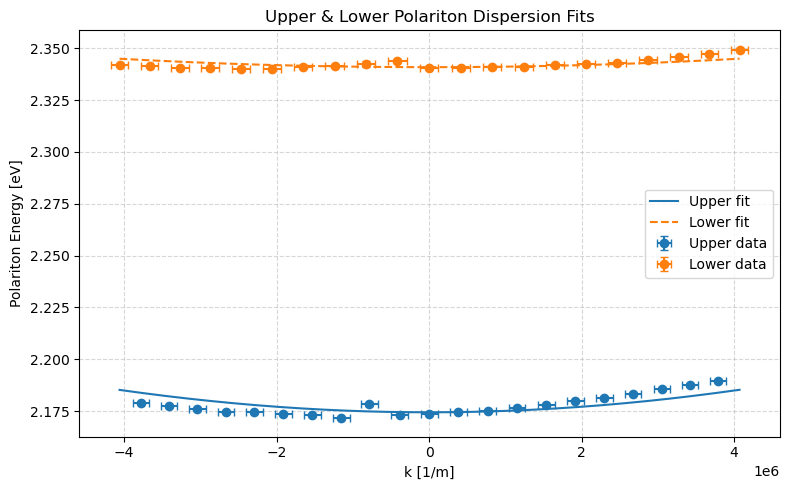

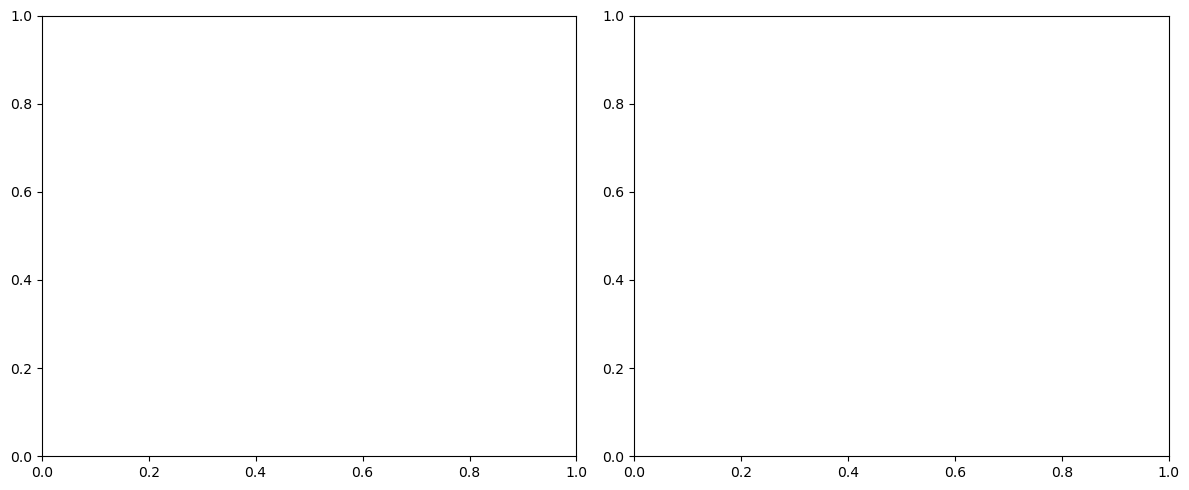

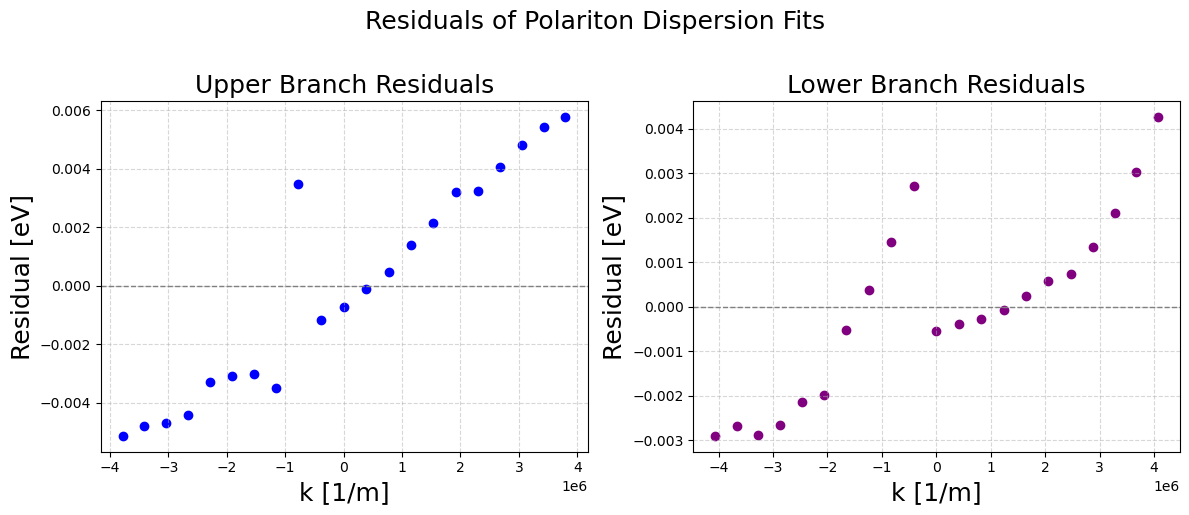

In [100]:
# Combined Grid‐Search, Parameter Printing, and Plot for Upper & Lower Polariton Branches
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

k_l = summary2['k_l'].values
E_l = summary2['Epol_l'].values
k_u = summary2['k_u'].values
E_u = summary2['Epol_u'].values

# constants you already know:
# (make sure to use consistent units throughout)
hbar = 1.0545718e-34
c    = 2.99792e8
qe = 1.602176634e-19   # J per eV

# Model functions
def E_upper(k, Al, n, L0, hO):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1*np.sqrt(k**2 + b2**2))**2 + 4*hO**2)
    return 0.5*(Al + b1*np.sqrt(k**2 + b2**2) - inside)

def E_lower(k, Al, n, L0, hO):
    b2 = np.pi / L0
    b1 = hbar * c / n
    inside = np.sqrt((Al - b1*np.sqrt(k**2 + b2**2))**2 + 4*hO**2)
    return 0.5*(Al + b1*np.sqrt(k**2 + b2**2) + inside)

# Initial guesses and ± range factors
Al_u0, n_u0, L0_u0, hO_u0 = 3.8e-19, 2.0, 105e-9, 5.2e-20
Al_l0, n_l0, L0_l0, hO_l0 = 3.5e-19, 2.8, 182e-9, 6.9e-20
factor_u, factor_l = 0.3, 0.2
N = 25  # grid resolution

# Build parameter grids for upper
Al_u_vals = np.linspace(Al_u0*(1-factor_u), Al_u0*(1+factor_u), N)
n_u_vals  = np.linspace(n_u0*(1-factor_u),  n_u0*(1+factor_u),  N)
L0_u_vals = np.linspace(L0_u0*(1-factor_u), L0_u0*(1+factor_u), N)
hO_u_vals = np.linspace(hO_u0*(1-factor_u), hO_u0*(1+factor_u), N)

# Build parameter grids for lower
Al_l_vals = np.linspace(Al_l0*(1-factor_l), Al_l0*(1+factor_l), N)
n_l_vals  = np.linspace(n_l0*(1-factor_l),  n_l0*(1+factor_l), N)
L0_l_vals = np.linspace(L0_l0*(1-factor_l), L0_l0*(1+factor_l), N)
hO_l_vals = np.linspace(hO_l0*(1-factor_l), hO_l0*(1+factor_l), N)

# Grid search for upper branch
best_cost_u = np.inf
best_params_u = None
for Al_x in Al_u_vals:
    for n_x in n_u_vals:
        for L0_x in L0_u_vals:
            for hO_x in hO_u_vals:
                pred = E_upper(k_u, Al_x, n_x, L0_x, hO_x)
                cost = np.sum((pred - E_u)**2)
                if cost < best_cost_u:
                    best_cost_u = cost
                    best_params_u = (Al_x, n_x, L0_x, hO_x)

# Grid search for lower branch
best_cost_l = np.inf
best_params_l = None
for Al_x in Al_l_vals:
    for n_x in n_l_vals:
        for L0_x in L0_l_vals:
            for hO_x in hO_l_vals:
                pred = E_lower(k_l, Al_x, n_x, L0_x, hO_x)
                cost = np.sum((pred - E_l)**2)
                if cost < best_cost_l:
                    best_cost_l = cost
                    best_params_l = (Al_x, n_x, L0_x, hO_x)

# ---- ERROR ESTIMATION SECTION START ----
# ... [error estimation code unchanged] ...
# ---- ERROR ESTIMATION SECTION END ----

# Print best‐fit parameters
# ... [printing code unchanged] ...

# Generate a common k‐axis
k_min = min(k_u.min(), k_l.min())
k_max = max(k_u.max(), k_l.max())
k_plot = np.linspace(k_min, k_max, 300)

# Compute fitted curves
E_u_fit = E_upper(k_plot, *best_params_u)
E_l_fit = E_lower(k_plot, *best_params_l)

# Combined plot
plt.figure(figsize=(8,5))
plt.errorbar(k_u, E_u/ qe, xerr=ku_err, yerr=Eu_err/ qe, fmt='o', color='C0', label='Upper data', capsize=3)
plt.plot(k_plot, E_upper(k_plot,*best_params_u)/qe, color='C0', label='Upper fit')
plt.errorbar(k_l, E_l/ qe, xerr=kl_err, yerr=El_err/ qe, fmt='o', color='C1', label='Lower data', capsize=3)
plt.plot(k_plot, E_lower(k_plot,*best_params_l)/qe, color='C1', linestyle='--', label='Lower fit')
plt.xlabel('k [1/m]')
plt.ylabel('Polariton Energy [eV]')
plt.title('Upper & Lower Polariton Dispersion Fits')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot the parameter correlations as heatmaps if covariance matrices are available
if 'pcov_u' in locals() and 'pcov_l' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # ... [correlation heatmap code unchanged] ...
    plt.tight_layout()
    plt.show()

# --- Added: Residuals Graph for Both Branches ---
# Compute residuals (in eV)
resid_u = -(E_upper(k_u, *best_params_u) - E_u) / qe
resid_l = -(E_lower(k_l, *best_params_l) - E_l) / qe

# Plot residuals
fig, (ax_u, ax_l) = plt.subplots(1, 2, figsize=(12, 5))

ax_u.scatter(k_u, resid_u, color='blue', label='Upper residuals')
ax_u.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_u.set_xlabel('k [1/m]', fontsize=18)
ax_u.set_ylabel('Residual [eV]', fontsize=18)
ax_u.set_title('Upper Branch Residuals', fontsize=18)
ax_u.grid(True, ls='--', alpha=0.5)

ax_l.scatter(k_l, resid_l, color='purple', label='Lower residuals')
ax_l.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_l.set_xlabel('k [1/m]', fontsize=18)
ax_l.set_ylabel('Residual [eV]', fontsize=18)
ax_l.set_title('Lower Branch Residuals', fontsize=18)
ax_l.grid(True, ls='--', alpha=0.5)

plt.suptitle('Residuals of Polariton Dispersion Fits', y=1.02, fontsize=18)
plt.tight_layout()
plt.show()
